In [1]:
# packages
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from functools import reduce


import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns

from typing import Tuple

import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.utils import resample

# local
from nb_util import autoreload, add_dirs
autoreload()

add_dirs(['../'])
from nash_util import concordance_stats as cs
from nash_util import nash_definitions as nd


In [2]:
# load Cougar network path data
file = 'REFDATA/COUGAR_NP_V02.xlsx'
c_dfs = {}

c_dfs['Fibrosis'] = pd.read_excel(file, sheet_name='Fibrosis')
c_dfs['Inflammation'] = pd.read_excel(file, sheet_name='Inflammation')
c_dfs['Ballooning'] = pd.read_excel(file, sheet_name='Ballooning')
c_dfs['Steatosis'] = pd.read_excel(file, sheet_name='Steatosis')

In [3]:
dfl = []
for k, df in c_dfs.items():
    df['Parameter'] = k
    dfl.append(df)
df_sav = pd.concat(dfl)

In [6]:
#138433
df_fib = df_sav[df_sav['Parameter']=='Fibrosis'].copy()
df_fib['CON'] = df_fib[['NP0','NP1','NP2']].apply(np.median,axis=1)
df_fib4 = df_fib[(df_fib['NP0']==4)|(df_fib['NP1']==4)|(df_fib['NP2']==4)]
pd.DataFrame(
    {'AIM':df_fib4['AIM'].value_counts(),
    'NP0':df_fib4['NP0'].value_counts(),
    'NP1':df_fib4['NP1'].value_counts(),
    'NP2':df_fib4['NP2'].value_counts(),
    'CON':df_fib4['CON'].value_counts()}).fillna(0)

,AIM,NP0,NP1,NP2,CON
1.0,0.0,1,0.0,0.0,0.0
2.0,2.0,1,0.0,0.0,0.0
3.0,37.0,50,40.0,6.0,40.0
4.0,27.0,14,23.0,59.0,23.0


In [ ]:
df_fib = df_sav[df_sav['Parameter']=='Fibrosis']


df_fib4 = df_fib[(df_fib['NP0']==4)|(df_fib['NP1']==4)|(df_fib['NP2']==4)]
pd.DataFrame(
    {'AIM':df_fib4['AIM'].value_counts(),
    'NP0':df_fib4['NP0'].value_counts(),
    'NP1':df_fib4['NP1'].value_counts(),
    'NP2':df_fib4['NP2'].value_counts()}).fillna(0).T

In [30]:
len(df_fib)

633

In [47]:
df_fib = df_sav[df_sav['Parameter']=='Fibrosis'].copy()
df_fib['CON'] = df_fib[['NP0','NP1','NP2']].apply(np.median,axis=1)
df_fib4con = df_fib[df_fib['CON']==4]
pd.DataFrame(
    {'AIM':df_fib4con['AIM'].value_counts(),
    'NP0':df_fib4con['NP0'].value_counts(),
    'NP1':df_fib4con['NP1'].value_counts(),
    'NP2':df_fib4con['NP2'].value_counts()}).T

,3.0,4.0
AIM,4,19
NP0,12,11
NP1,4,19
NP2,1,22


In [48]:
df_fib['Any F4'] = (df_fib['NP0']==4)|(df_fib['NP1']==4)|(df_fib['NP2']==4)
df_fib['Unique NP Scores'] = df_fib[['NP0','NP1','NP2']].apply(lambda r: len(np.unique(r)),axis=1)

In [49]:
pd.DataFrame(df_fib[['CON','Unique NP Scores']].value_counts()).reset_index().pivot(index='CON', columns=['Unique NP Scores']).fillna(0)

0             
Unique NP Scores      1      2     3
CON                                 
0.0                 2.0   13.0   0.0
1.0                22.0  109.0  28.0
2.0                26.0   94.0  26.0
3.0               161.0  115.0   2.0
4.0                 6.0   17.0   0.0

In [50]:
pd.DataFrame(df_fib[['Any F4','Unique NP Scores']].value_counts()).reset_index().pivot(index='Any F4', columns=['Unique NP Scores']).fillna(0)

0         
Unique NP Scores    1    2   3
Any F4                        
False             211  296  60
True                6   56   4

In [15]:
df_fib4['NP1'].value_counts()

3.0    40
4.0    23
Name: NP1, dtype: int64

In [16]:
df_fib4['NP2'].value_counts()

4.0    59
3.0     6
Name: NP2, dtype: int64

In [4]:
ex_df = df_sav.copy()
ex_df['CON'] = ex_df[['NP0','NP1','NP2']].apply(np.median,axis=1)
ex_df[ex_df['PATHAI_ID'].isin([198507,198899])][['PATHAI_ID','Parameter','AIM','CON']].sort_values('PATHAI_ID')

,PATHAI_ID,Parameter,AIM,CON
321,198507,Inflammation,0,1.0
321,198507,Ballooning,0,0.0
321,198507,Steatosis,0,0.0
572,198899,Inflammation,1,2.0
572,198899,Ballooning,2,2.0
572,198899,Steatosis,3,3.0


In [15]:
# pairwise statistics
metric_dict = {
    'Kappa': cs.kappa,
#     'Agree Rate': cs.agg_rate,
#     'Disc. Rate': cs.disc_rate,
#     'Disc. >1 Rate':cs.disc_2_rate,
#     'Mean Bias':cs.mean_diff,
#     'Abs. Mean Bias':cs.mean_diff,
#     'Overcall Rate (CON > . )':cs.overcall_rate,
#     'Undercall Rate (CON < . )':cs.undercall_rate,
}
abs_metrics = ['Abs. Mean Bias']
df_list = []

df_test = df_sav[(df_sav['Parameter']=='Fibrosis')&(df_sav['AIM'].isin([0,1]))].copy()
# df_test = df_sav[(df_sav['Parameter']=='Fibrosis')].copy()

for comp in ['Fibrosis']:

    df = df_test[df_test['Parameter']==comp]
    aim = df['AIM']
    np0 = df['NP0']
    np1 = df['NP1']
    np2 = df['NP2']
    
    for k, fn in metric_dict.items():
        if k in abs_metrics:
            do_abs=True
        else:
            do_abs=False
        df_temp, _ = cs.pairwise_stats(fn, aim, np0, np1, np2, stratify=aim,do_abs=do_abs)
        df_temp['NASH Component'] = comp
        df_temp['Metric']=k
        df_list.append(df_temp)

df_pw_multistat = pd.concat(df_list)

In [14]:
# all
df_pw_multistat

,AIM PW AVG,NP PW AVG,NP0-NP1,NP0-NP2,NP1-NP2,N,NASH Component,Metric
0,"0.36 (0.32, 0.39)","0.35 (0.32, 0.38)","0.44 (0.39, 0.49)","0.25 (0.21, 0.29)","0.35 (0.3, 0.39)",621,Fibrosis,Kappa


In [16]:
# F0, F1
df_pw_multistat

,AIM PW AVG,NP PW AVG,NP0-NP1,NP0-NP2,NP1-NP2,N,NASH Component,Metric
0,"0.05 (-0.04, 0.14)","0.15 (0.08, 0.23)","0.28 (0.13, 0.43)","0.13 (0.05, 0.21)","0.05 (-0.04, 0.14)",109,Fibrosis,Kappa


In [ ]:
# pairwise statistics
metric_dict = {
    'Kappa': cs.kappa_lin,
    'Agree Rate': cs.agg_rate,
    'Disc. Rate': cs.disc_rate,
    'Disc. >1 Rate':cs.disc_2_rate,
    'Mean Bias':cs.mean_diff,
    'Abs. Mean Bias':cs.mean_diff,
    'Overcall Rate (CON > . )':cs.overcall_rate,
    'Undercall Rate (CON < . )':cs.undercall_rate,
}
abs_metrics = ['Abs. Mean Bias']
df_list = []
for comp, df in c_dfs.items():

    aim = df['AIM']
    np0 = df['NP0']
    np1 = df['NP1']
    np2 = df['NP2']
    
    for k, fn in metric_dict.items():
        if k in abs_metrics:
            do_abs=True
        else:
            do_abs=False
        df_temp, _ = cs.pairwise_stats(fn, aim, np0, np1, np2, stratify=aim,do_abs=do_abs)
        df_temp['NASH Component'] = comp
        df_temp['Metric']=k
        df_list.append(df_temp)

df_pw_multistat = pd.concat(df_list)
display(df_pw_multistat)

In [ ]:
# grand med statistics
metric_dict = {
    'Kappa': cs.kappa_lin,
    'Agree Rate': cs.agg_rate,
    'Disc. Rate': cs.disc_rate,
    'Disc. >1 Rate':cs.disc_2_rate,
    'Mean Bias':cs.mean_diff,
    'Abs. Mean Bias':cs.mean_diff,
    'Overcall Rate (CON > . )':cs.overcall_rate,
    'Undercall Rate (CON < . )':cs.undercall_rate,
}
abs_metrics = ['Abs. Mean Bias']
df_list = []
for comp, df in c_dfs.items():

    aim = df['AIM']
    np0 = df['NP0']
    np1 = df['NP1']
    np2 = df['NP2']
    
    for k, fn in metric_dict.items():
        if k in abs_metrics:
            do_abs=True
        else:
            do_abs=False
        df_temp, _ = cs.grand_med_stats(fn, aim, np0, np1, np2, stratify=aim,do_abs=do_abs)
        df_temp['NASH Component'] = comp
        df_temp['Metric']=k
        df_list.append(df_temp)

df_grandmed_multistat = pd.concat(df_list)
display(df_grandmed_multistat)

In [ ]:
# loo statistics
metric_dict = {
    'Kappa': cs.kappa_lin,
    'Agree Rate': cs.agg_rate,
    'Disc. Rate': cs.disc_rate,
    'Disc. >1 Rate':cs.disc_2_rate,
    'Mean Bias':cs.mean_diff,
    'Abs. Mean Bias':cs.mean_diff,
    'Overcall Rate (CON > . )':cs.overcall_rate,
    'Undercall Rate (CON < . )':cs.undercall_rate,
}
abs_metrics = ['Abs. Mean Bias']
df_list = []
for comp, df in c_dfs.items():

    aim = df['AIM']
    np0 = df['NP0']
    np1 = df['NP1']
    np2 = df['NP2']
    
    for k, fn in metric_dict.items():
        if k in abs_metrics:
            do_abs=True
        else:
            do_abs=False
        df_temp, _ = cs.loo_stats(fn, aim, np0, np1, np2, stratify=aim,do_abs=do_abs)
        df_temp['NASH Component'] = comp
        df_temp['Metric']=k
        df_list.append(df_temp)

df_loo_multistat = pd.concat(df_list)
display(df_loo_multistat)

In [ ]:
# gloo statistics
metric_dict = {
    'Kappa': cs.kappa_lin,
    'Agree Rate': cs.agg_rate,
    'Disc. Rate': cs.disc_rate,
    'Disc. >1 Rate':cs.disc_2_rate,
    'Mean Bias':cs.mean_diff,
    'Abs. Mean Bias':cs.mean_diff,
    'Overcall Rate ( . > CON )':cs.overcall_rate,
    'Undercall Rate ( . < CON )':cs.undercall_rate,
}
abs_metrics = ['Abs. Mean Bias']
df_list = []
for comp, df in c_dfs.items():

    aim = df['AIM']
    np0 = df['NP0']
    np1 = df['NP1']
    np2 = df['NP2']
    
    con = np.median([np0,np1,np2],axis=1)
    
    for k, fn in metric_dict.items():
        if k in abs_metrics:
            do_abs=True
        else:
            do_abs=False
        df_temp, _ = cs.grand_loo_stats(fn, aim, np0, np1, np2, stratify=aim,do_abs=do_abs)
        df_temp['NASH Component'] = comp
        df_temp['Metric']=k
        df_list.append(df_temp)

df_gloo_multistat = pd.concat(df_list)
display(df_gloo_multistat)

In [157]:
df_t = c_dfs['Fibrosis'].copy()
df_t = df_t.dropna(subset=['NP0','NP1','NP2'])
df_t['con'] = df_t[['NP0','NP1','NP2']].apply(np.median,axis=1)

print('Kappa')
test = df_t.copy()
print('All\t',np.around(cs.kappa_lin(test['con'],test['AIM']),2))

test = df_t[df_t['con']>=3].copy()
print('F3-F4\t',np.around(cs.kappa_lin(test['con'],test['AIM']),2))

test = df_t[df_t['con']<3].copy()
print('F0-F2\t',np.around(cs.kappa_lin(test['con'],test['AIM']),2))

df_t = c_dfs['Fibrosis'].copy()
df_t = df_t.dropna(subset=['NP0','NP1','NP2'])
df_t['con'] = df_t[['NP0','NP1','NP2']].apply(np.median,axis=1)

print('Agg. Rate')
test = df_t.copy()
print('All\t',np.around(cs.agg_rate(test['con'],test['AIM']),2))

test = df_t[df_t['con']>=3].copy()
print('F3-F4\t',np.around(cs.agg_rate(test['con'],test['AIM']),2))

test = df_t[df_t['con']<3].copy()
print('F0-F2\t',np.around(cs.agg_rate(test['con'],test['AIM']),2))

Kappa
All	 0.58
F3-F4	 0.37
F0-F2	 0.25
Agg. Rate
All	 0.62
F3-F4	 0.83
F0-F2	 0.42


In [158]:
df_t = c_dfs['Fibrosis'].copy()
df_t = df_t.dropna(subset=['NP0','NP1','NP2'])
df_t['con'] = df_t[['NP0','NP1','NP2']].apply(np.median,axis=1)

print('Kappa')
test = df_t.copy()
test['con'].value_counts()

Kappa


3.0    278
1.0    159
2.0    146
4.0     23
0.0     15
Name: con, dtype: int64

In [156]:
df_t = c_dfs['Fibrosis'].copy()
df_t = df_t.dropna(subset=['NP0','NP1','NP2'])
df_t['con'] = df_t[['NP0','NP1','NP2']].apply(np.median,axis=1)

print('Kappa')
test = df_t.copy()
print('All\t',np.around(cs.kappa_lin(test['con'],test['AIM']),2))

test = df_t[df_t['con']>=2].copy()
print('F2-F4\t',np.around(cs.kappa_lin(test['con'],test['AIM']),2))

test = df_t[df_t['con']<2].copy()
print('F0-F1\t',np.around(cs.kappa_lin(test['con'],test['AIM']),2))

df_t = c_dfs['Fibrosis'].copy()
df_t = df_t.dropna(subset=['NP0','NP1','NP2'])
df_t['con'] = df_t[['NP0','NP1','NP2']].apply(np.median,axis=1)

print('Agg. Rate')
test = df_t.copy()
print('All\t',np.around(cs.agg_rate(test['con'],test['AIM']),2))

test = df_t[df_t['con']>=2].copy()
print('F2-F4\t',np.around(cs.agg_rate(test['con'],test['AIM']),2))

test = df_t[df_t['con']<2].copy()
print('F0-F1\t',np.around(cs.agg_rate(test['con'],test['AIM']),2))

Kappa
All	 0.58
F2-F4	 0.51
F0-F1	 0.05
Agg. Rate
All	 0.62
F2-F4	 0.72
F0-F1	 0.34


In [145]:
df_t['con'].value_counts()

3.0    278
4.0     23
Name: con, dtype: int64

In [ ]:
# gloo statistics
metric_dict = {
    'Kappa': cs.kappa_lin,
}
abs_metrics = ['Abs. Mean Bias']
df_list = []
for comp, df in c_dfs.items():
    if comp != 'Fibrosis':
        continue
    df_t = df.copy()
    df_t = df_t.dropna(subset=['NP0','NP1','NP2'])
    df_t['con'] = df_t[['NP0','NP1','NP2']].apply(np.median,axis=1)
    df_t = df_t[df_t['con']>=3]
    aim = df_t['AIM']
    np0 = df_t['NP0']
    np1 = df_t['NP1']
    np2 = df_t['NP2']
    
    con = np.median([np0,np1,np2],axis=1)
    
    for k, fn in metric_dict.items():
        if k in abs_metrics:
            do_abs=True
        else:
            do_abs=False
        df_temp, _ = cs.grand_loo_stats(fn, aim, np0, np1, np2, stratify=con,do_abs=do_abs)
        df_temp['NASH Component'] = comp
        df_temp['Metric']=k
        df_list.append(df_temp)

df_gloo_multistat_f34 = pd.concat(df_list)
display(df_gloo_multistat_f34)

In [ ]:
# gloo statistics
metric_dict = {
    'Kappa': cs.kappa_lin,
}
abs_metrics = ['Abs. Mean Bias']
df_list = []
for comp, df in c_dfs.items():
    if comp != 'Fibrosis':
        continue
    df_t = df.copy()
    df_t['con'] = df_t[['NP0','NP1','NP2']].apply(np.median,axis=1)
    df_t = df_t[df_t['con']<3]
    aim = df['AIM']
    np0 = df['NP0']
    np1 = df['NP1']
    np2 = df['NP2']
    
    con = np.median([np0,np1,np2],axis=1)
    
    for k, fn in metric_dict.items():
        if k in abs_metrics:
            do_abs=True
        else:
            do_abs=False
        df_temp, _ = cs.grand_loo_stats(fn, aim, np0, np1, np2, stratify=con,do_abs=do_abs)
        df_temp['NASH Component'] = comp
        df_temp['Metric']=k
        df_list.append(df_temp)

df_gloo_multistat_f012 = pd.concat(df_list)
display(df_gloo_multistat_f012)

In [ ]:
# legacy statistics
metric_dict = {
    'Kappa': cs.kappa_lin,
    'Agree Rate': cs.agg_rate,
    'Disc. Rate': cs.disc_rate,
    'Disc. >1 Rate':cs.disc_2_rate,
    'Mean Bias':cs.mean_diff,
    'Abs. Mean Bias':cs.mean_diff,
    'Overcall Rate (CON > . )':cs.overcall_rate,
    'Undercall Rate (CON < . )':cs.undercall_rate,
}
abs_metrics = ['Abs. Mean Bias']
df_list = []
for comp, df in c_dfs.items():

    aim = df['AIM']
    np0 = df['NP0']
    np1 = df['NP1']
    np2 = df['NP2']
    
    for k, fn in metric_dict.items():
        if k in abs_metrics:
            do_abs=True
        else:
            do_abs=False
        df_temp, _ = cs.legacy_stats(fn, aim, np0, np1, np2, stratify=aim,do_abs=do_abs)
        df_temp['NASH Component'] = comp
        df_temp['Metric']=k
        df_list.append(df_temp)

df_legacy_multistat = pd.concat(df_list)
display(df_legacy_multistat)

In [103]:
def all_disc_stats(a,b):
    return np.array([
        np.sum(a==b),
        np.sum((np.abs(a-b)>0)&(np.abs(a-b)<=1)),
        np.sum(np.abs(a-b)>1)
    ])

def aim_con_disc(a,b):
    ab = all_disc_stats(a,b)
    return ab/np.sum(ab)

def pairwise_disc(a,b,c):
    ab = all_disc_stats(a,b)
    ac = all_disc_stats(a,c)
    bc = all_disc_stats(b,c)
    
    ab = ab/np.sum(ab)
    ac = ac/np.sum(ac)
    bc = bc/np.sum(bc)
    
    
    abc_min = np.array([
        np.min([ab[0],ac[0],bc[0]]),
        np.min([ab[1],ac[1],bc[1]]),
        np.min([ab[2],ac[2],bc[2]])
    ]) 
    
    abc_max = np.array([
        np.max([ab[0],ac[0],bc[0]]),
        np.max([ab[1],ac[1],bc[1]]),
        np.max([ab[2],ac[2],bc[2]])
    ]) 
    
    abc_avg = (ab+ac+bc)/3.0
    
    return abc_avg, abc_min, abc_max


In [83]:
a = [np.array([1,2,3]),np.array([4,5,6]),np.array([4,5,6])]
np.percentile(np.array(a),[10,90],axis=1)[0,:]

array([1.2, 4.2, 4.2])

In [114]:
# plots
df_list = []
for comp, df in c_dfs.items():
    
    aim = df['AIM']
    np0 = df['NP0']
    np1 = df['NP1']
    np2 = df['NP2']
    
    aim,np0,np1,np2  = cs.clean_nans([aim,np0,np1,np2])
    con = np.median([np0,np1,np2],axis=0)
    
    print(comp)
    ac = aim_con_disc(aim,con)
    print(ac)
    pw_all = pairwise_disc(np0,np1,np2)
    print(pw_all)
    
    bs_aim = []
    bs_pw = []
    
    for ii in range(10000):
        aim_bs, np0_bs, np1_bs, np2_bs, con_bs = resample(aim, np0, np1, np2, con, stratify=con)
        bs_aim.append(aim_con_disc(aim_bs, con_bs))
        pw,_,_ = pairwise_disc(np0_bs, np1_bs, np2_bs)
        bs_pw.append(pw)

    ci_aim = np.percentile(np.array(bs_aim), [2.5, 97.5],axis=0)
    ci_pw = np.percentile(np.array(bs_pw), [2.5, 97.5],axis=0)
    
    df_list.append(pd.DataFrame({
            'Parameter':[comp]*3,
            'Comparison':['AIM-CON']*3,
            'Abs. Delta':['0','1','2+'],
            'Rate':ac,
            'Rate (LB)':ci_aim[0,:],
            'Rate (UB)':ci_aim[1,:],
        }))
    df_list.append(pd.DataFrame({
        'Parameter':[comp]*3,
        'Comparison':['INTER-PATH']*3,
        'Abs. Delta':['0','1','2+'],
        'Rate':pw_all[0],
        'Rate (LB)':ci_pw[0,:],
        'Rate (UB)':ci_pw[1,:],
    }))
    
disc_stats_pw = pd.concat(df_list)


Fibrosis
[0.61674718 0.34460548 0.03864734]
(array([0.53623188, 0.38378959, 0.07997853]), array([0.4589372 , 0.34782609, 0.04669887]), array([0.60547504, 0.43478261, 0.10628019]))
Inflammation
[0.67246835 0.32594937 0.00158228]
(array([0.57594937, 0.40295359, 0.02109705]), array([0.54746835, 0.38765823, 0.00316456]), array([0.59493671, 0.4193038 , 0.03322785]))
Ballooning
[0.69730586 0.29635499 0.00633914]
(array([0.61384046, 0.36344427, 0.02271527]), array([0.57686212, 0.32329635, 0.0110935 ]), array([0.66561014, 0.3866878 , 0.04278922]))
Steatosis
[0.74050633 0.25632911 0.00316456]
(array([0.625     , 0.35443038, 0.02056962]), array([0.5664557 , 0.32120253, 0.01582278]), array([0.66297468, 0.41297468, 0.02531646]))


In [126]:
# plots
df_list = []
for comp, df in c_dfs.items():
    
    aim = df['AIM']
    np0 = df['NP0']
    np1 = df['NP1']
    np2 = df['NP2']
    
    aim,np0,np1,np2  = cs.clean_nans([aim,np0,np1,np2])
    con_aim = np.median([np0,np1,np2],axis=0)
    con_0 = np.median([aim,np1,np2],axis=0)
    con_1 = np.median([np0,aim,np2],axis=0)
    con_2 = np.median([np0,np1,aim],axis=0)
    
    def ret_disc(a,c_u,c_d):
        a1 = aim_con_disc(a,c_u)
        a2 = aim_con_disc(a,c_d)
        return (a1+a2)/2.0
    
    ac = aim_con_disc(aim,con_aim)
    
    pw0 = aim_con_disc(np0,con_0)
    pw1 = aim_con_disc(np1,con_1)
    pw2 = aim_con_disc(np2,con_2)

    pw_all = (pw0+pw1+pw2)/3.0
    
    bs_aim = []
    bs_pw = []
    
    for ii in range(10000):
        aim_bs, np0_bs, np1_bs, np2_bs, con_a_bs,con_0_bs,con_1_bs,con_2_bs = resample(aim, np0, np1, np2, con_aim,con_0,con_1,con_2, stratify=con_aim)
        
        ac_bs = aim_con_disc(aim_bs,con_a_bs)
        pw0 = aim_con_disc(np0_bs,con_0_bs)
        pw1 = aim_con_disc(np1_bs,con_1_bs)
        pw2 = aim_con_disc(np2_bs,con_2_bs)
        
        bs_aim.append(ac_bs)
        bs_pw.append((pw0+pw1+pw2)/3.0)

    ci_aim = np.percentile(np.array(bs_aim), [2.5, 97.5],axis=0)
    ci_pw = np.percentile(np.array(bs_pw), [2.5, 97.5],axis=0)
    
    df_list.append(pd.DataFrame({
            'Parameter':[comp]*3,
            'Comparison':['AIM-CON']*3,
            'Abs. Delta':['0','1','2+'],
            'Rate':ac,
            'Rate (LB)':ci_aim[0,:],
            'Rate (UB)':ci_aim[1,:],
        }))
    df_list.append(pd.DataFrame({
        'Parameter':[comp]*3,
        'Comparison':['PATH-CON']*3,
        'Abs. Delta':['0','1','2+'],
        'Rate':pw_all,
        'Rate (LB)':ci_pw[0,:],
        'Rate (UB)':ci_pw[1,:],
    }))
    
disc_stats_gloo = pd.concat(df_list)


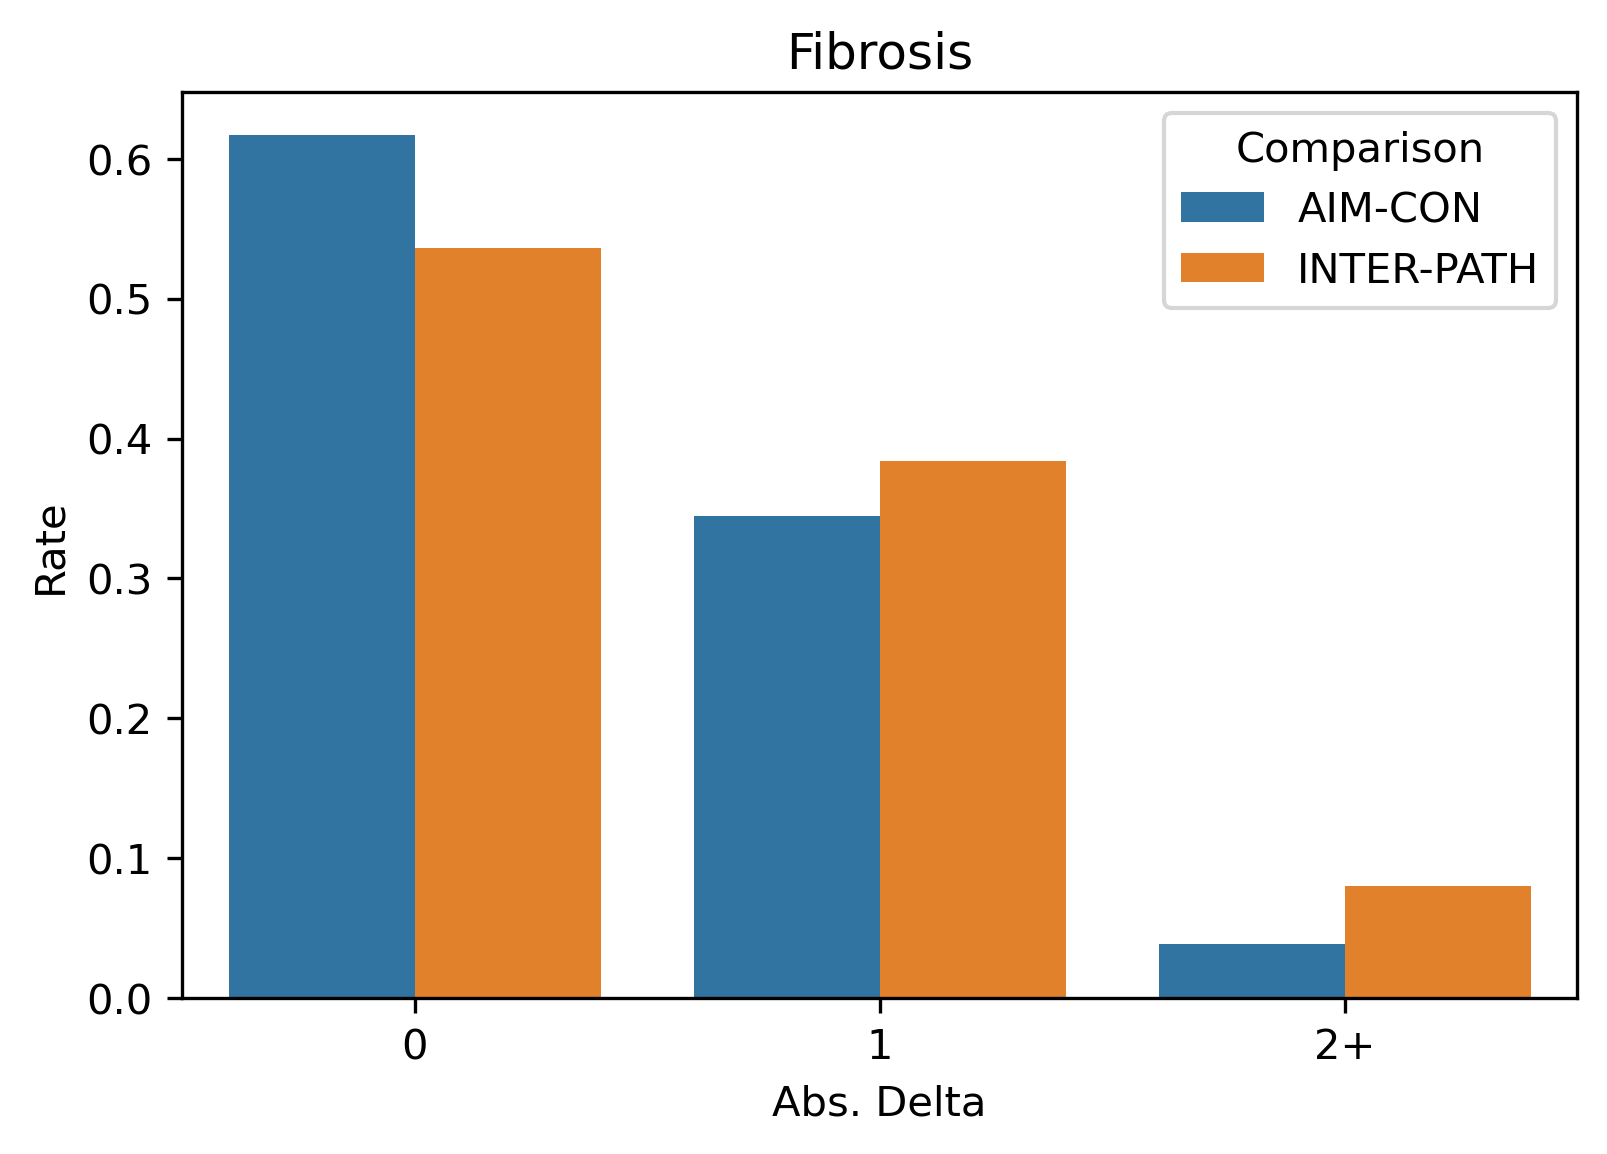

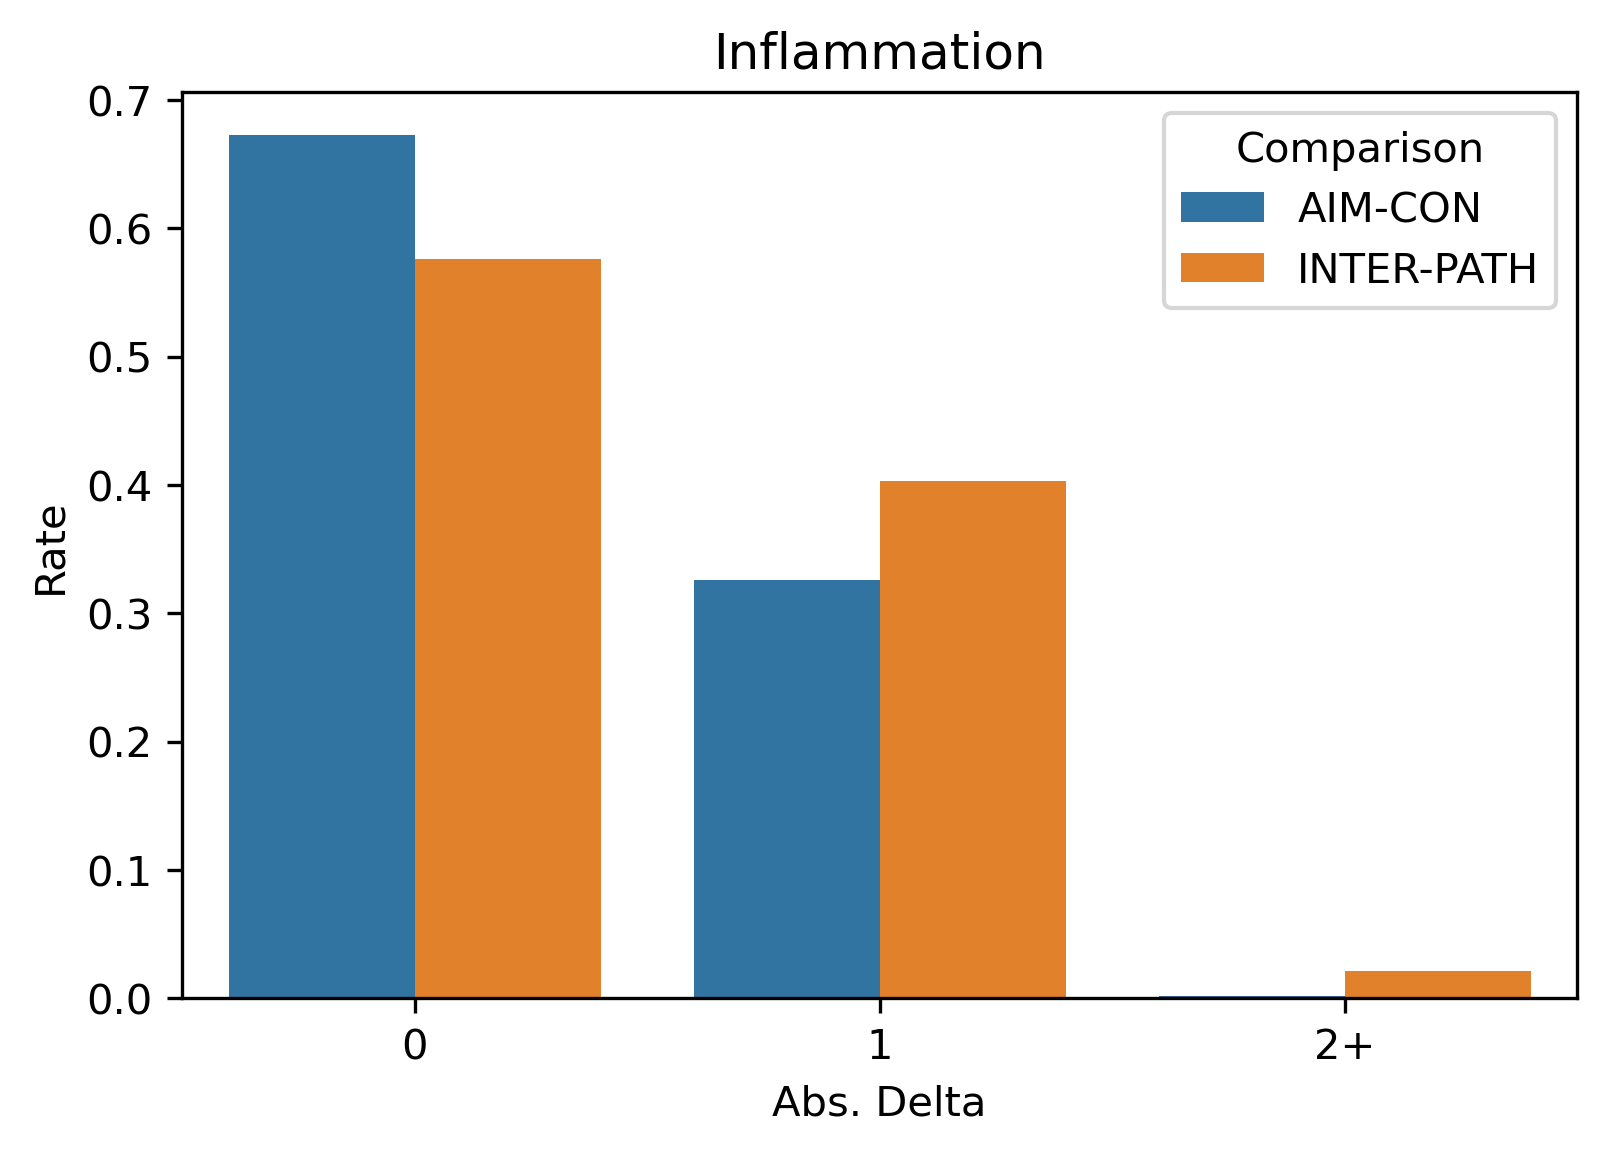

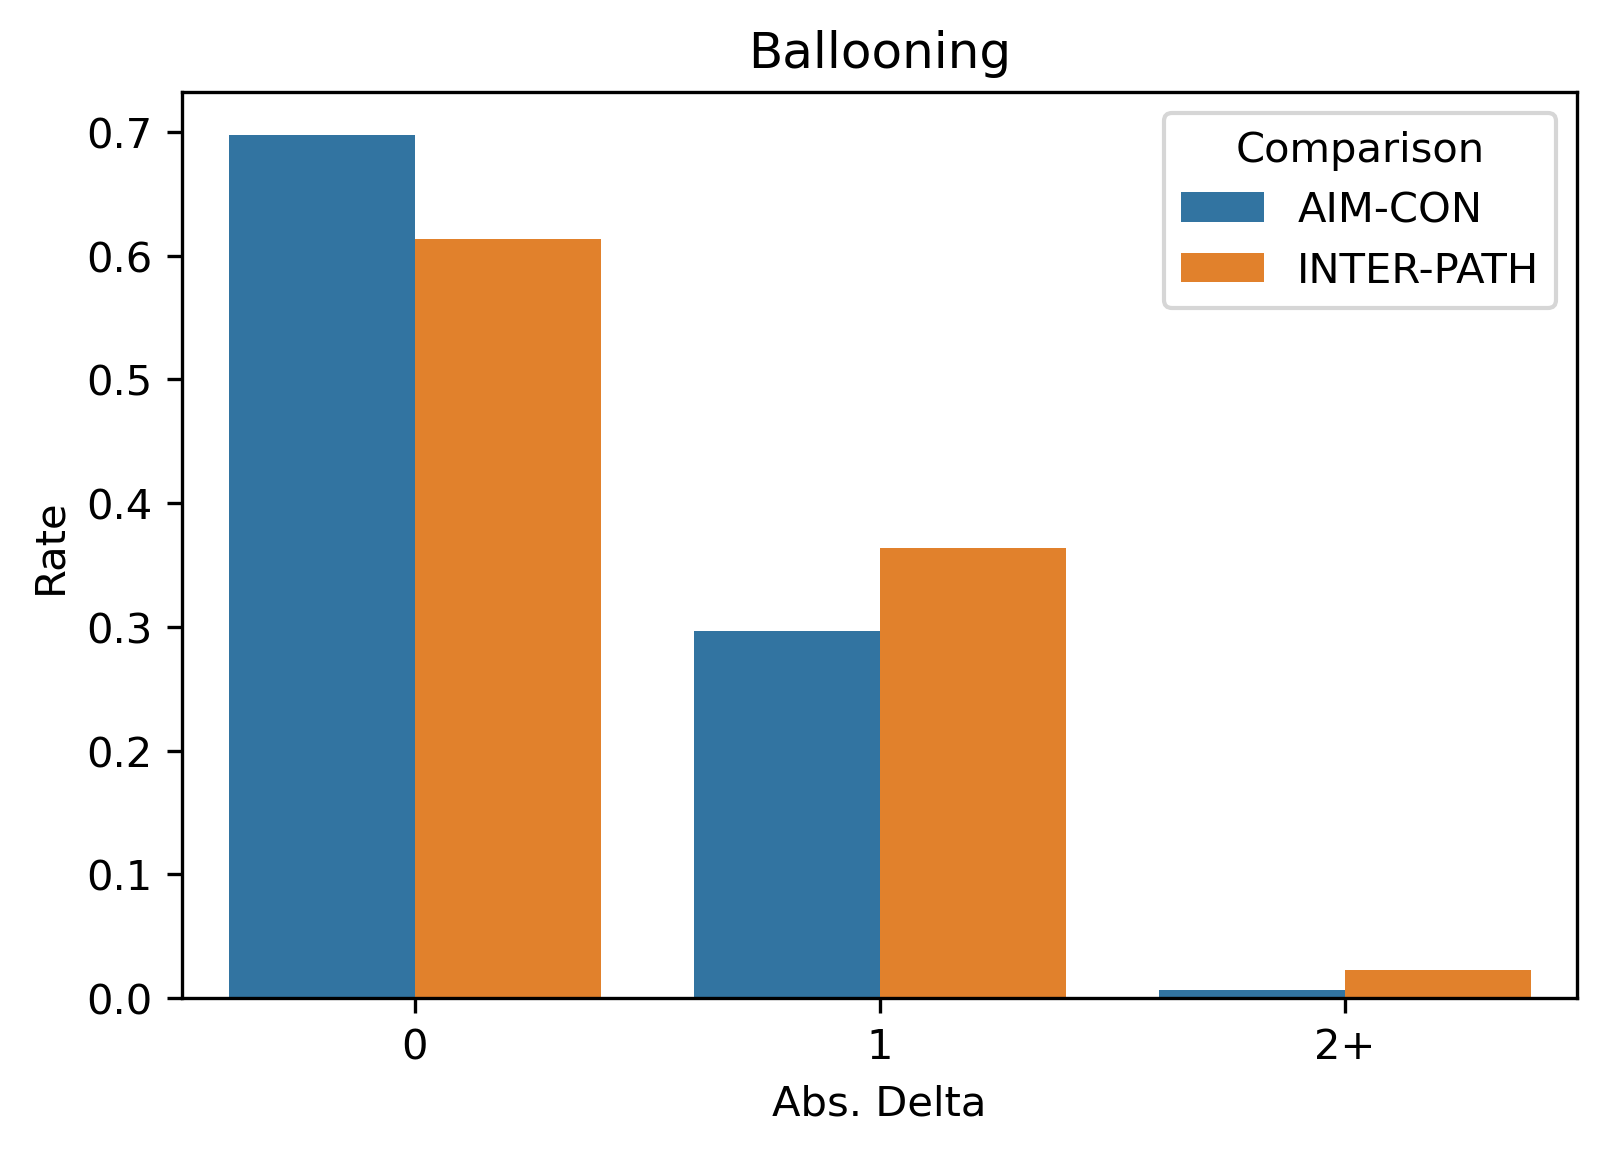

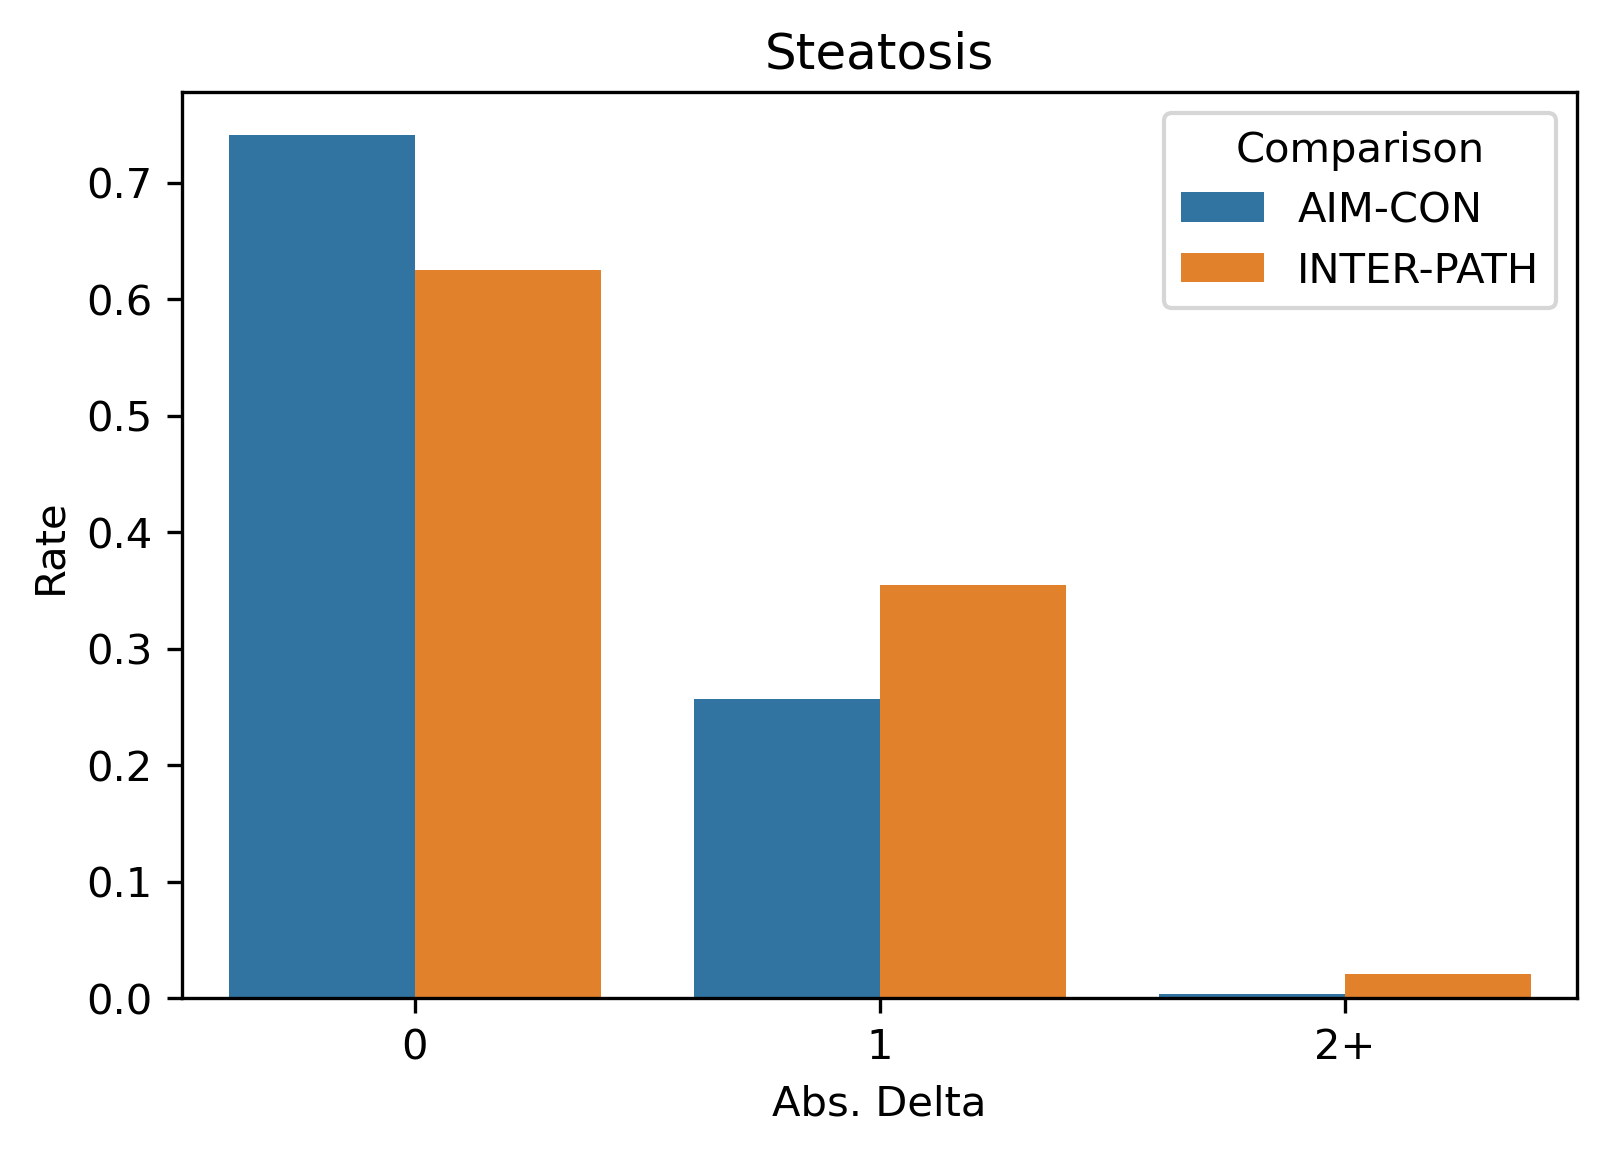

In [129]:
for comp in ['Fibrosis','Inflammation','Ballooning','Steatosis']:
    ax = sns.barplot(data = disc_stats[disc_stats['Parameter']==comp], x = 'Abs. Delta',y='Rate',hue='Comparison')
    ax.set_title(comp)
    plt.show()

In [117]:
disc_stats_pw

,Parameter,Comparison,Abs. Delta,Rate,Rate (LB),Rate (UB)
0,Fibrosis,AIM-CON,0,0.616747,0.582931,0.650564
1,Fibrosis,AIM-CON,1,0.344605,0.310789,0.378422
2,Fibrosis,AIM-CON,2+,0.038647,0.024155,0.053140
0,Fibrosis,INTER-PATH,0,0.536232,0.511541,0.560923
1,Fibrosis,INTER-PATH,1,0.383790,0.360709,0.406334
2,Fibrosis,INTER-PATH,2+,0.079979,0.066023,0.095008
0,Inflammation,AIM-CON,0,0.672468,0.636076,0.708861
1,Inflammation,AIM-CON,1,0.325949,0.289557,0.362342
2,Inflammation,AIM-CON,2+,0.001582,0.000000,0.004747
0,Inflammation,INTER-PATH,0,0.575949,0.549578,0.602321


In [127]:
disc_stats_gloo

,Parameter,Comparison,Abs. Delta,Rate,Rate (LB),Rate (UB)
0,Fibrosis,AIM-CON,0,0.616747,0.582931,0.650564
1,Fibrosis,AIM-CON,1,0.344605,0.310789,0.378422
2,Fibrosis,AIM-CON,2+,0.038647,0.024155,0.054750
0,Fibrosis,PATH-CON,0,0.593666,0.566291,0.620505
1,Fibrosis,PATH-CON,1,0.358561,0.332797,0.384326
2,Fibrosis,PATH-CON,2+,0.047772,0.037037,0.059581
0,Inflammation,AIM-CON,0,0.672468,0.636076,0.707278
1,Inflammation,AIM-CON,1,0.325949,0.291139,0.362342
2,Inflammation,AIM-CON,2+,0.001582,0.000000,0.004747
0,Inflammation,PATH-CON,0,0.644515,0.615506,0.671941


In [46]:
g[mask]

array(['6\n(0.01)', '3\n(0.0)', '70\n(0.11)', '0\n(0.0)', '13\n(0.02)',
       '54\n(0.09)', '0\n(0.0)', '1\n(0.0)', '0\n(0.0)', '14\n(0.02)'],
      dtype='<U10')

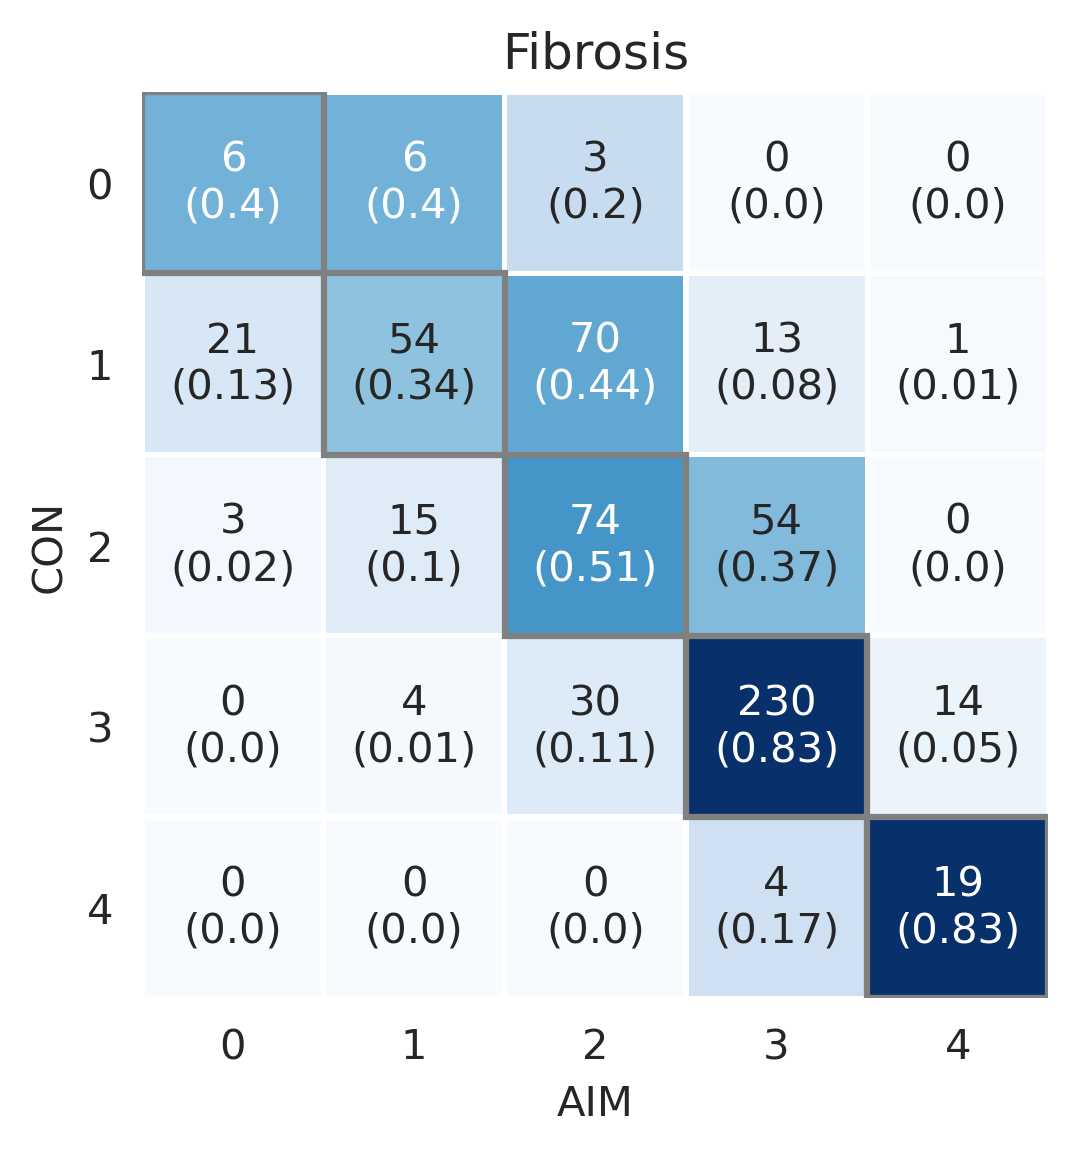

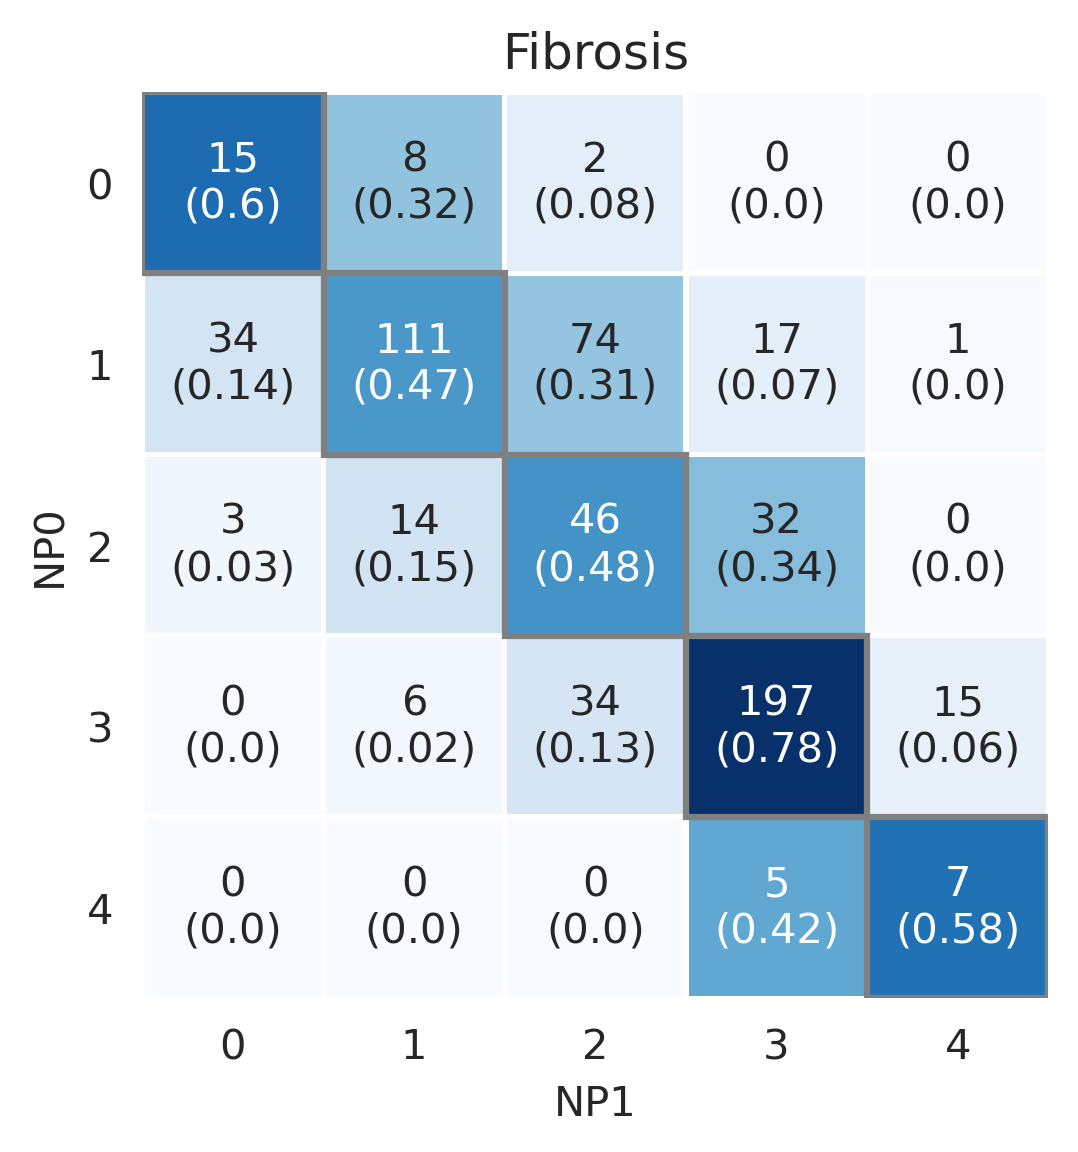

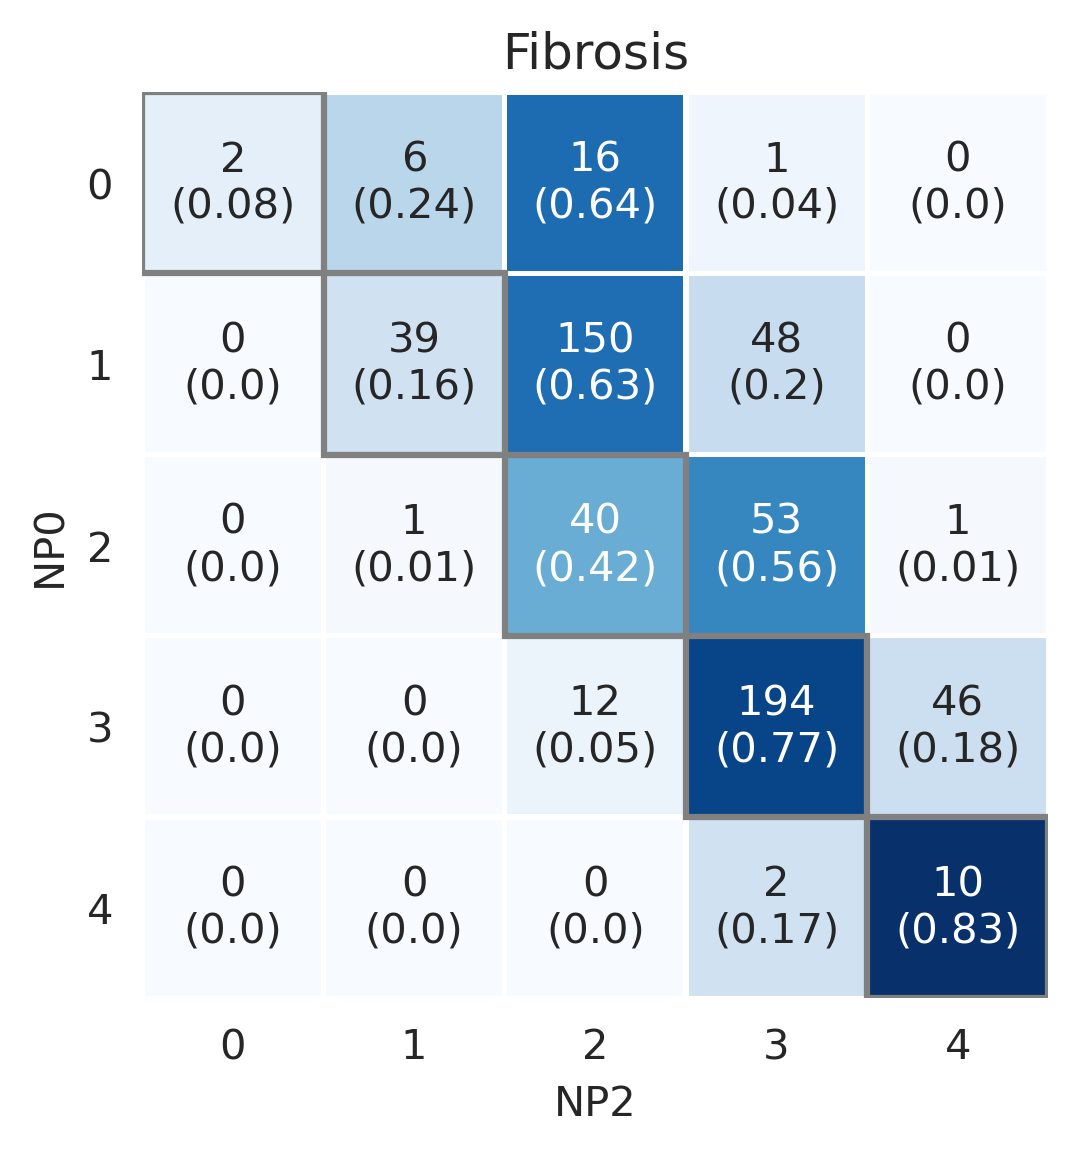

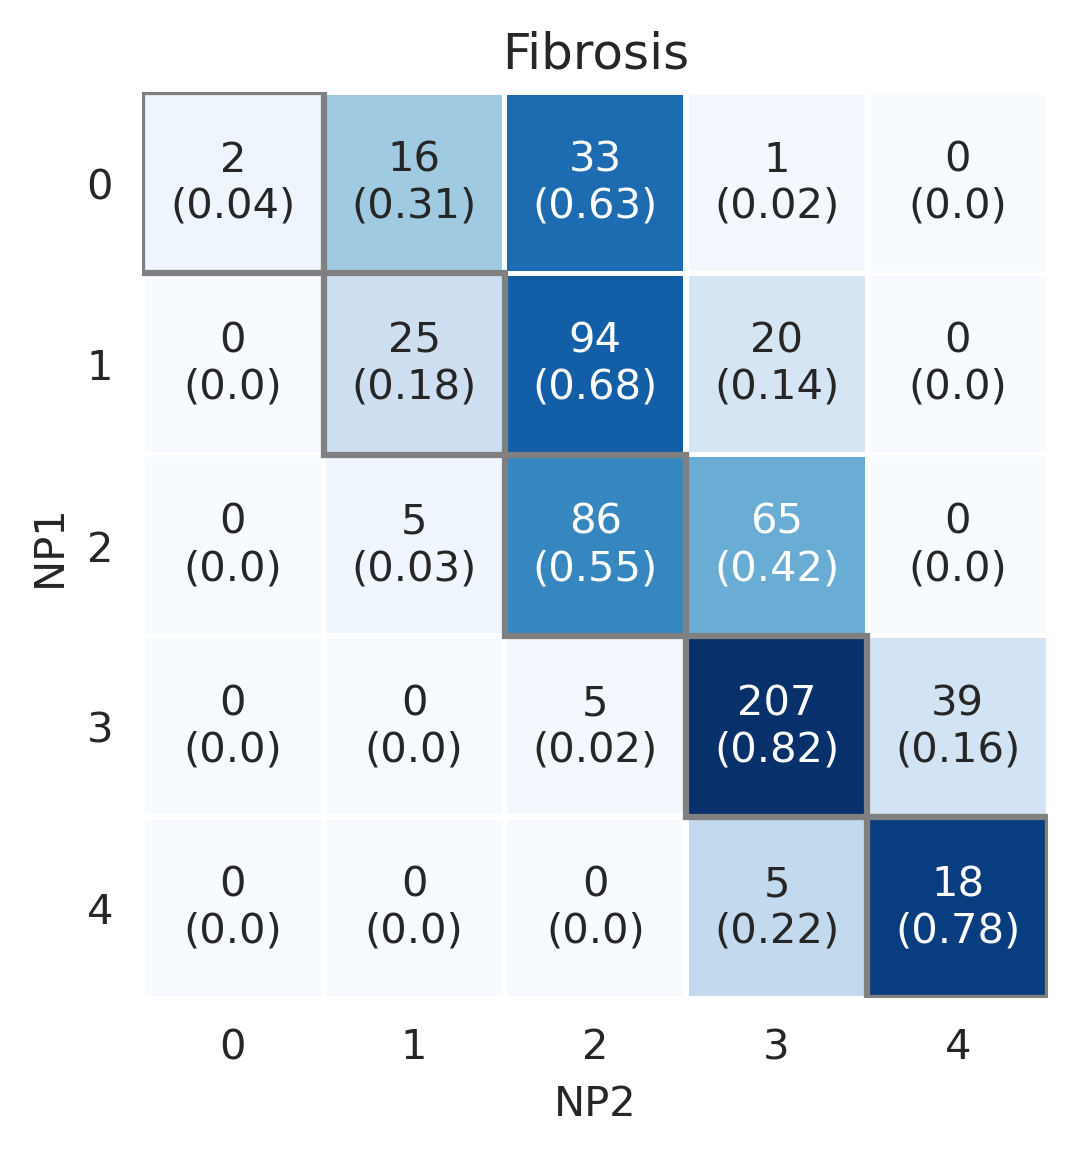

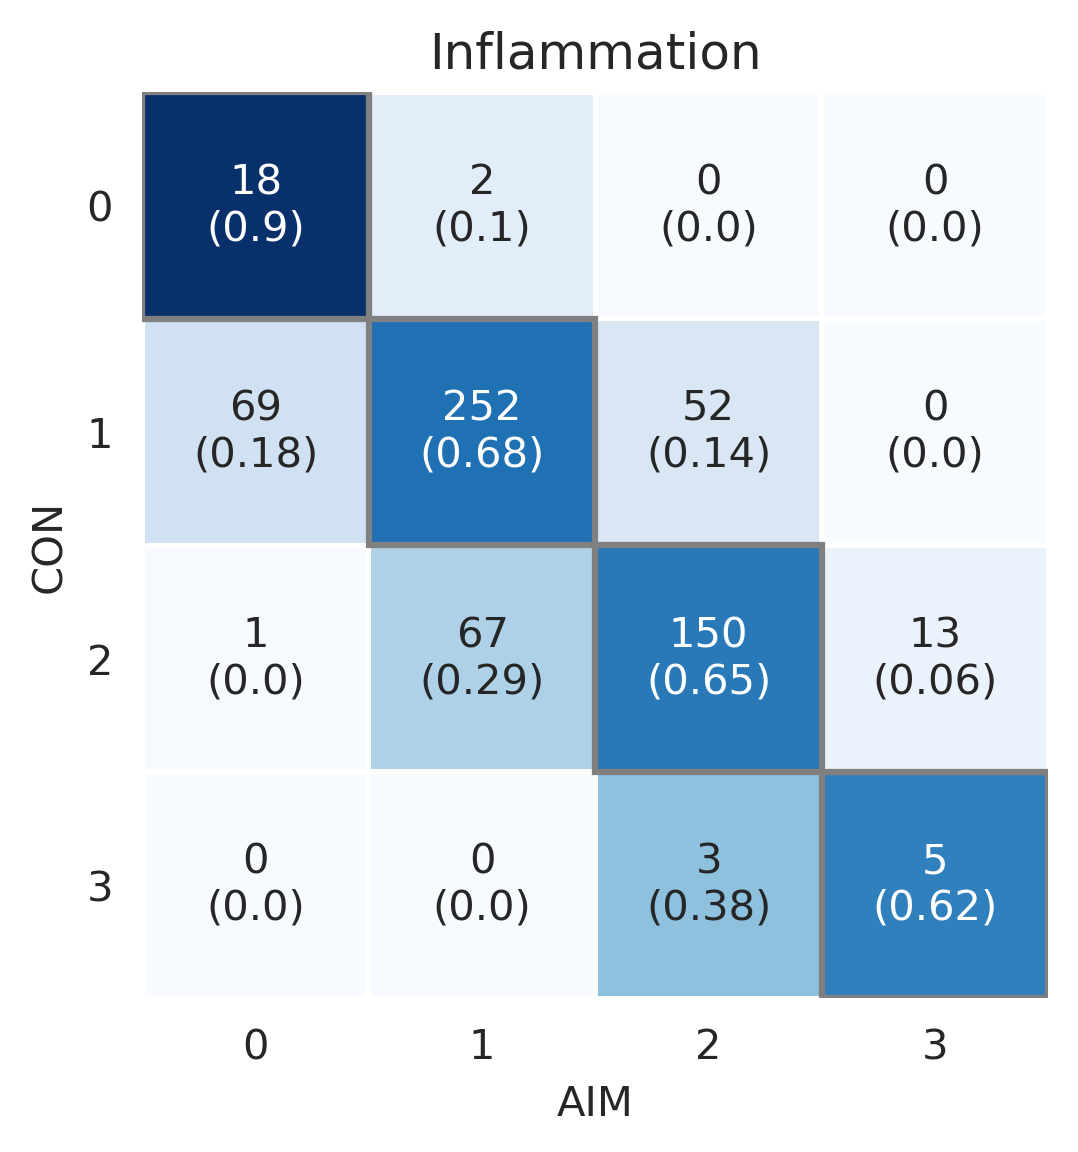

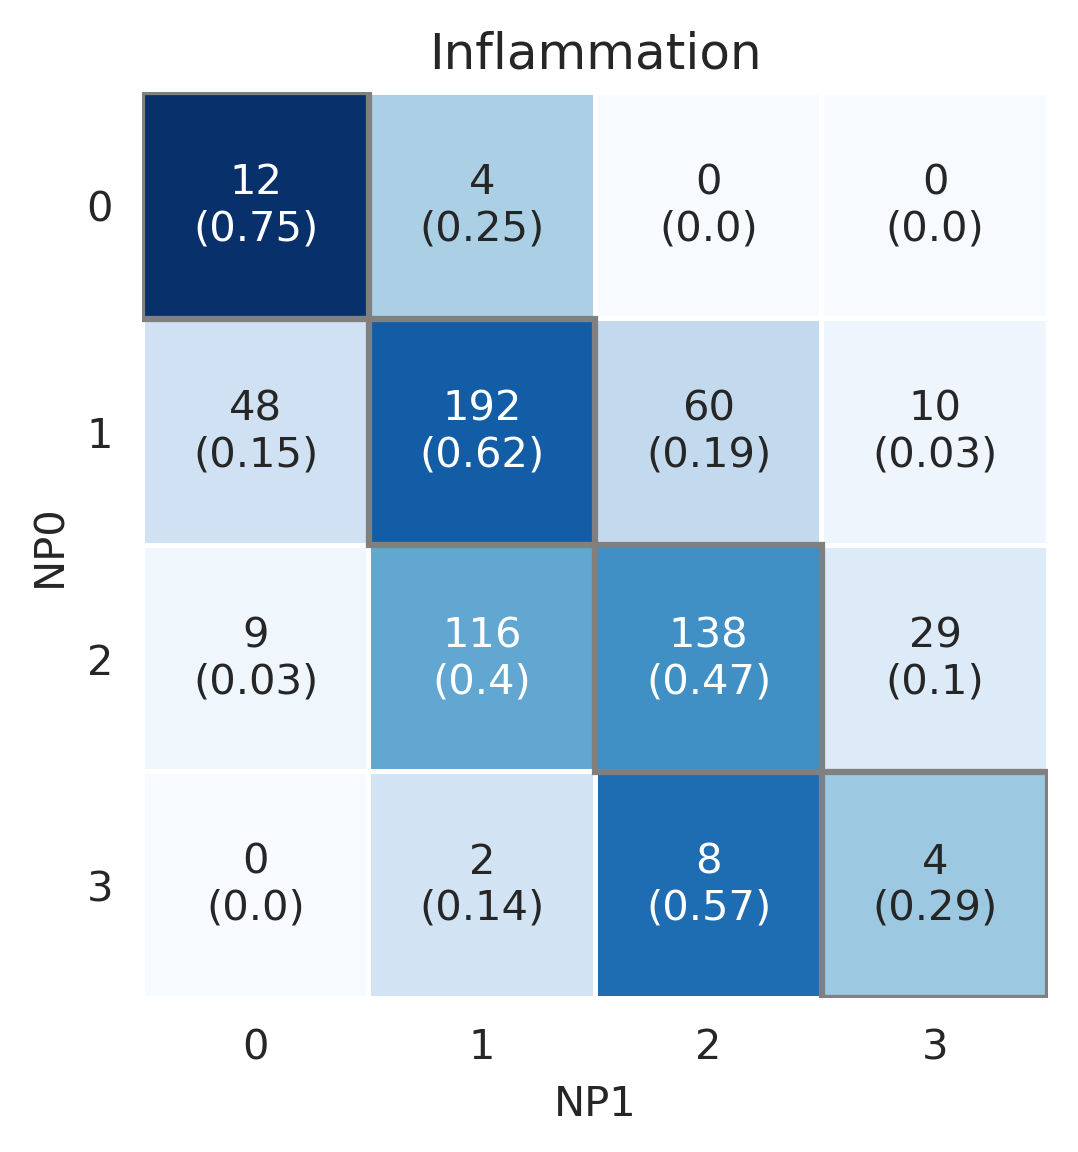

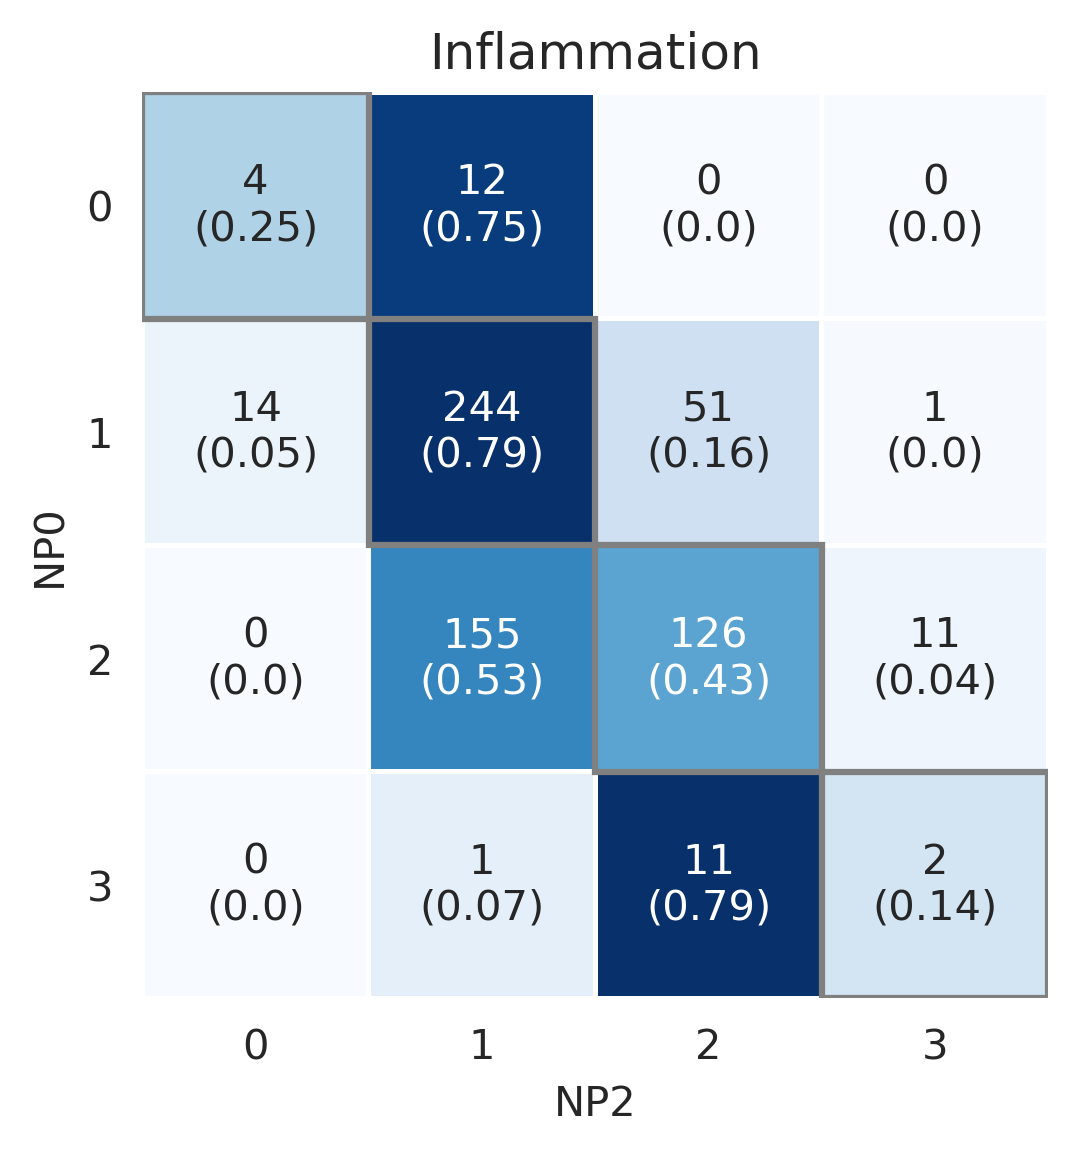

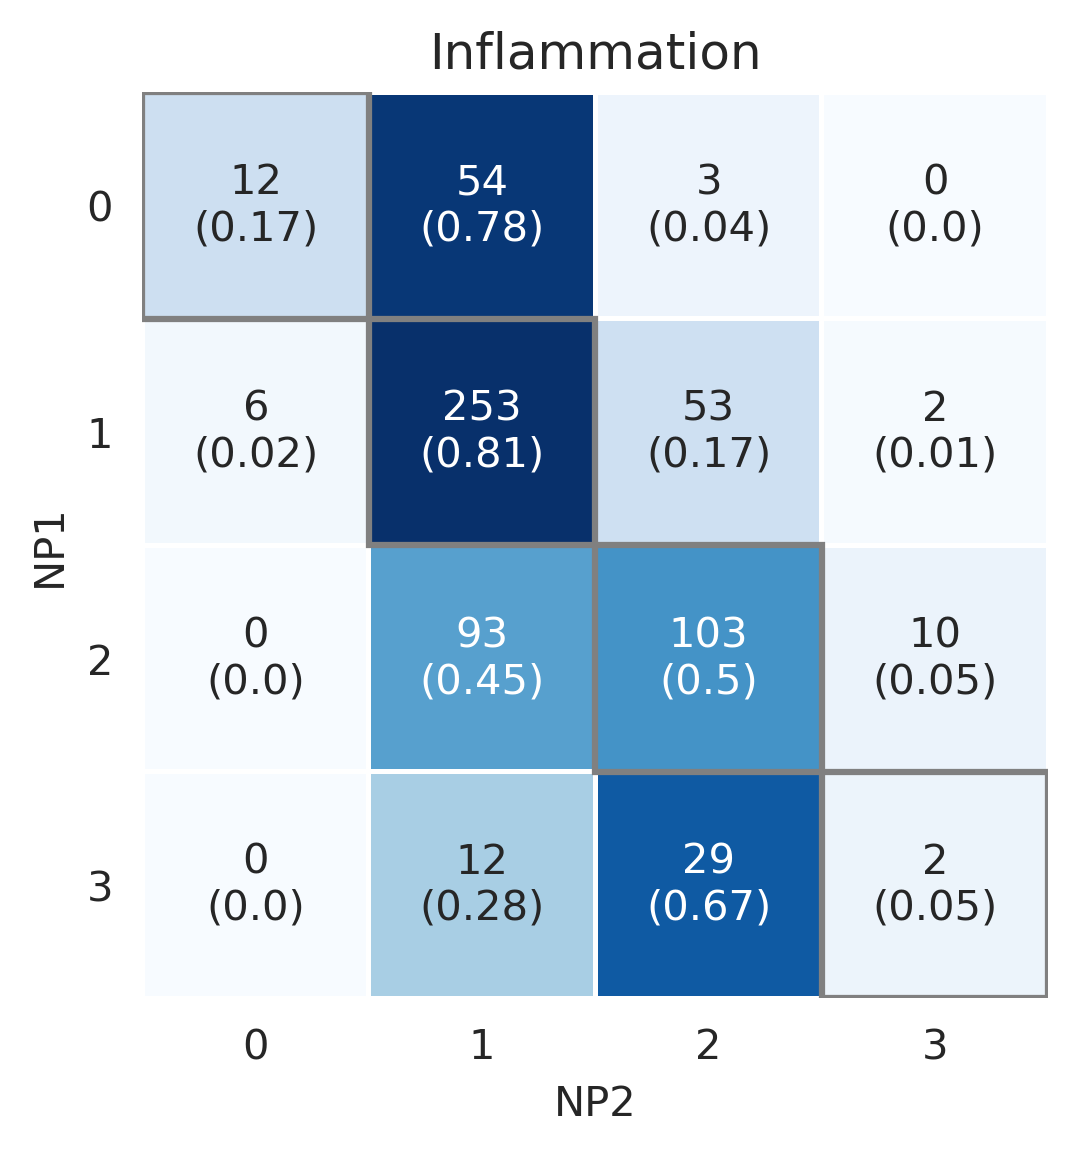

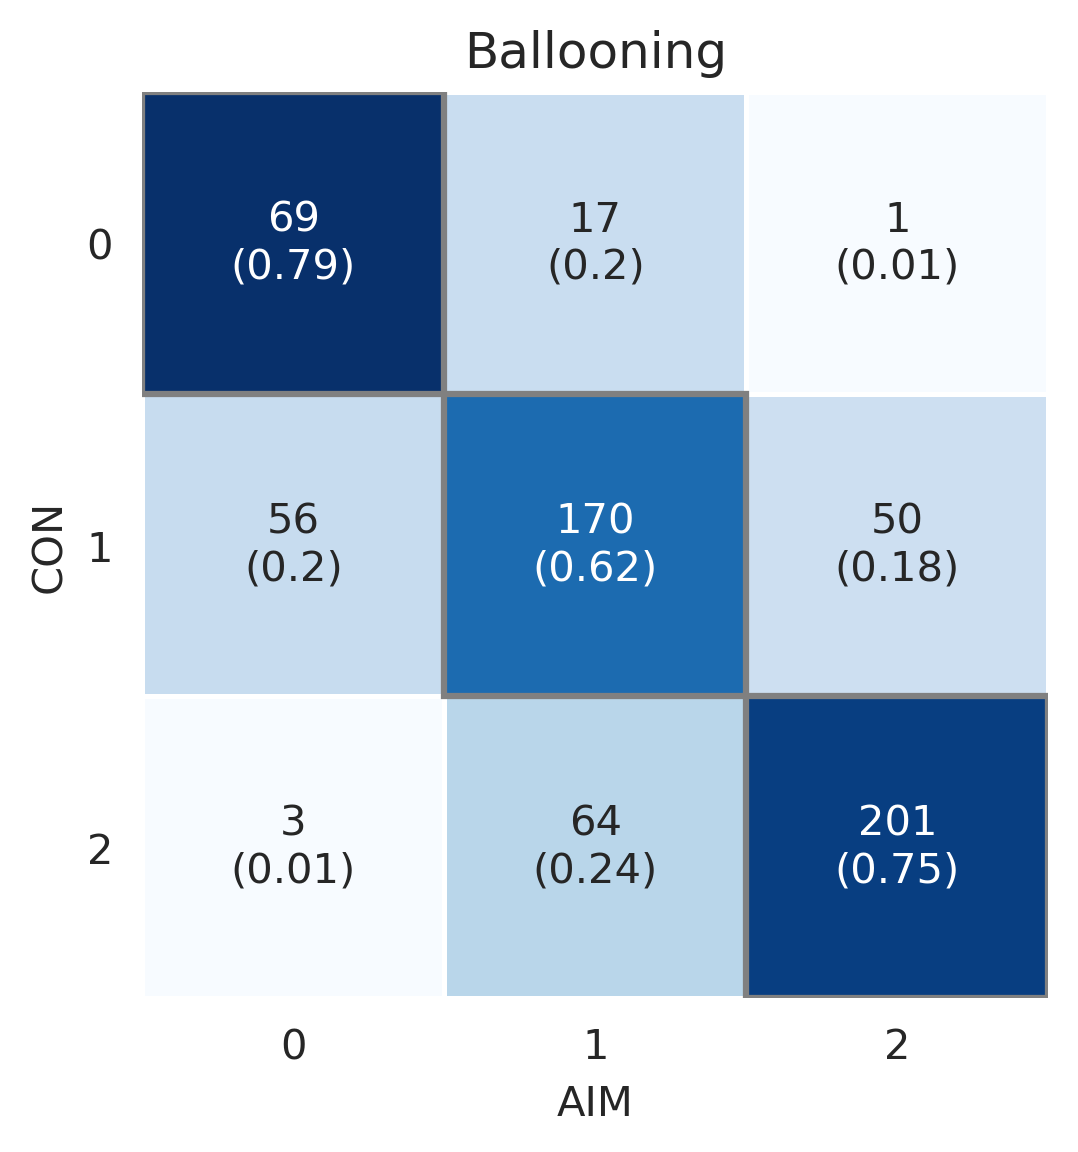

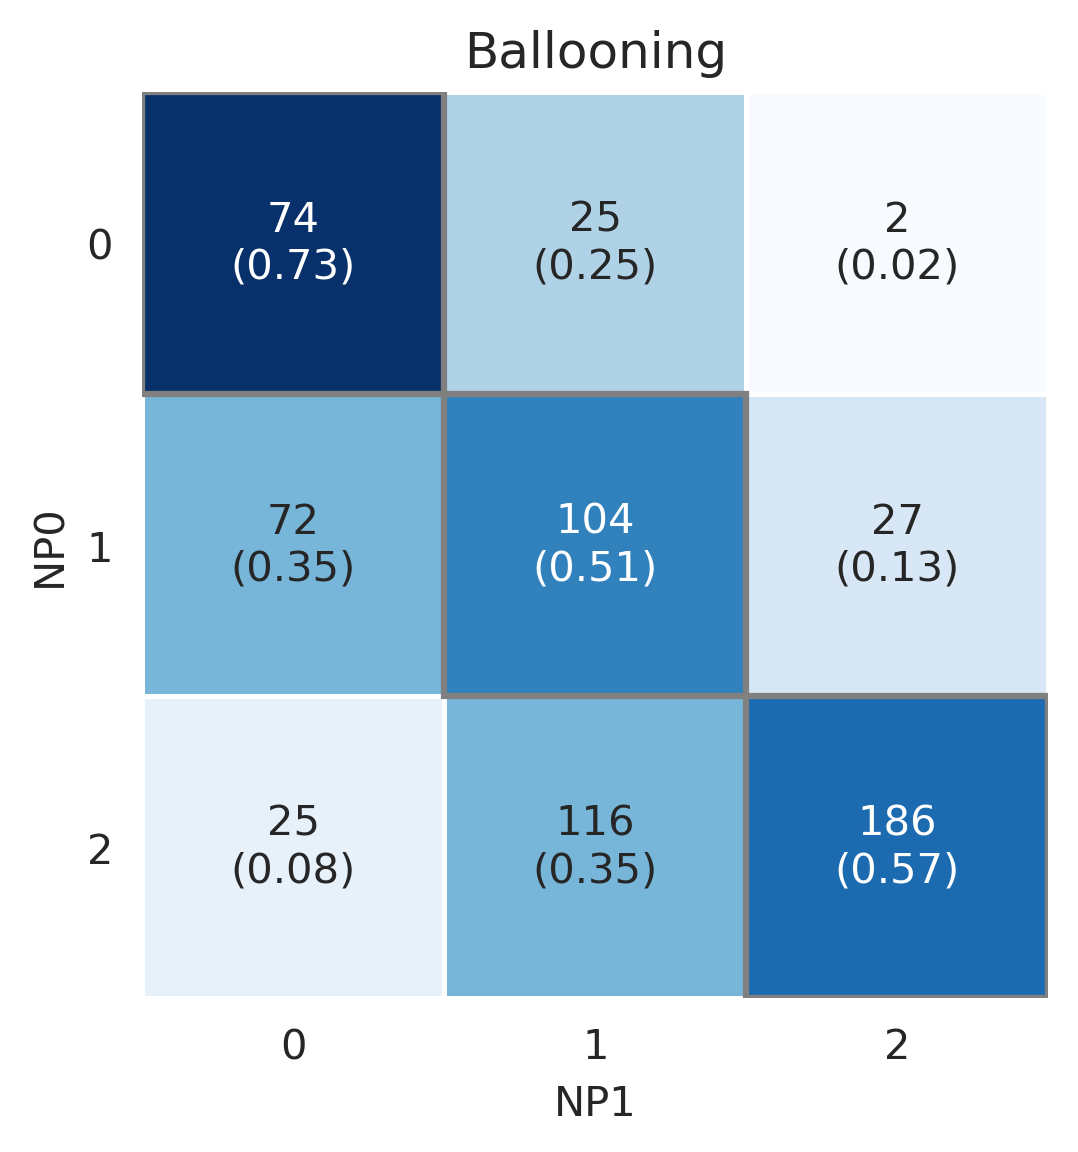

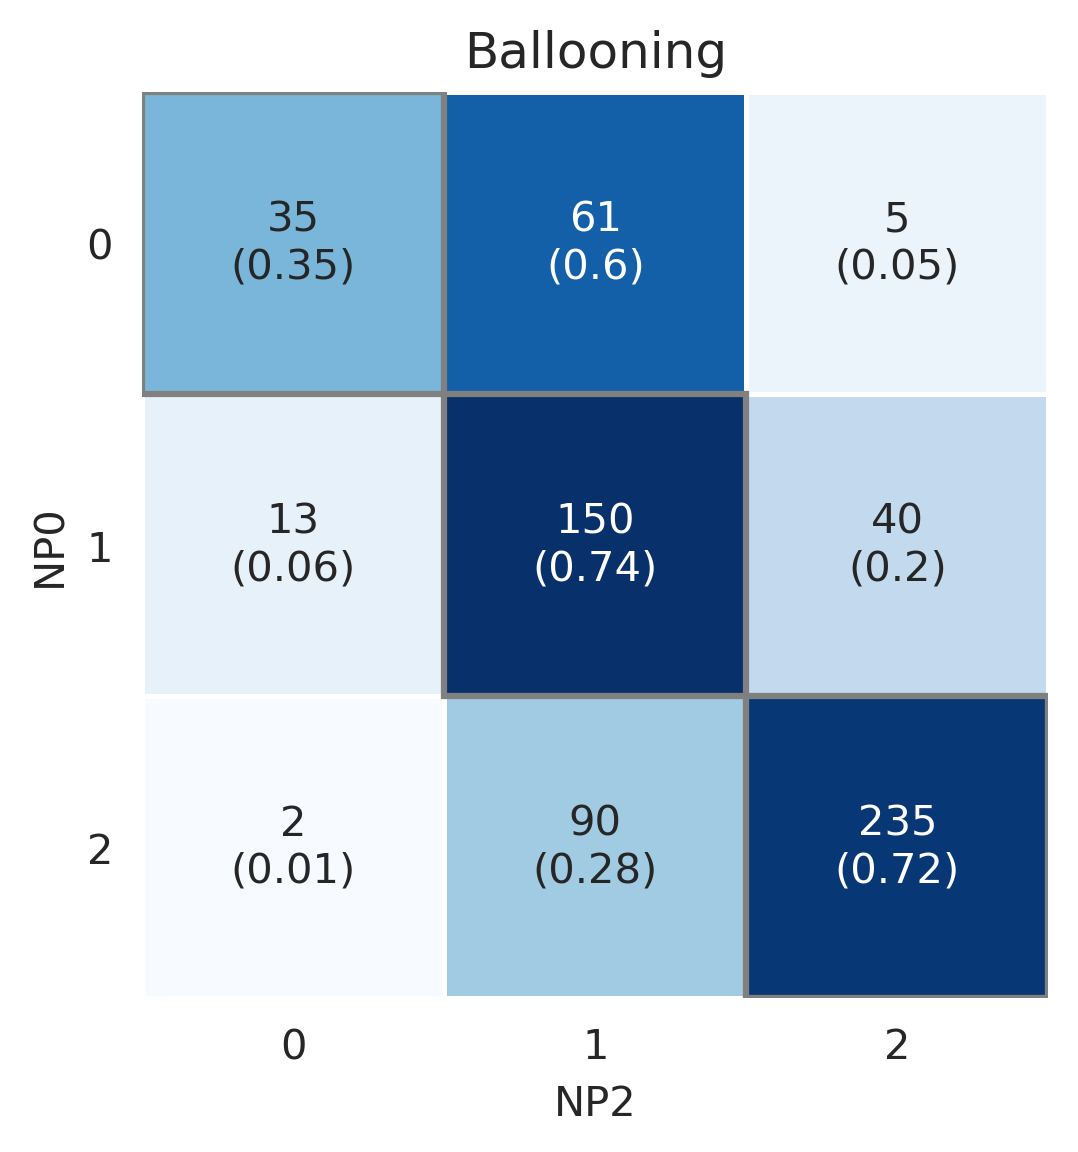

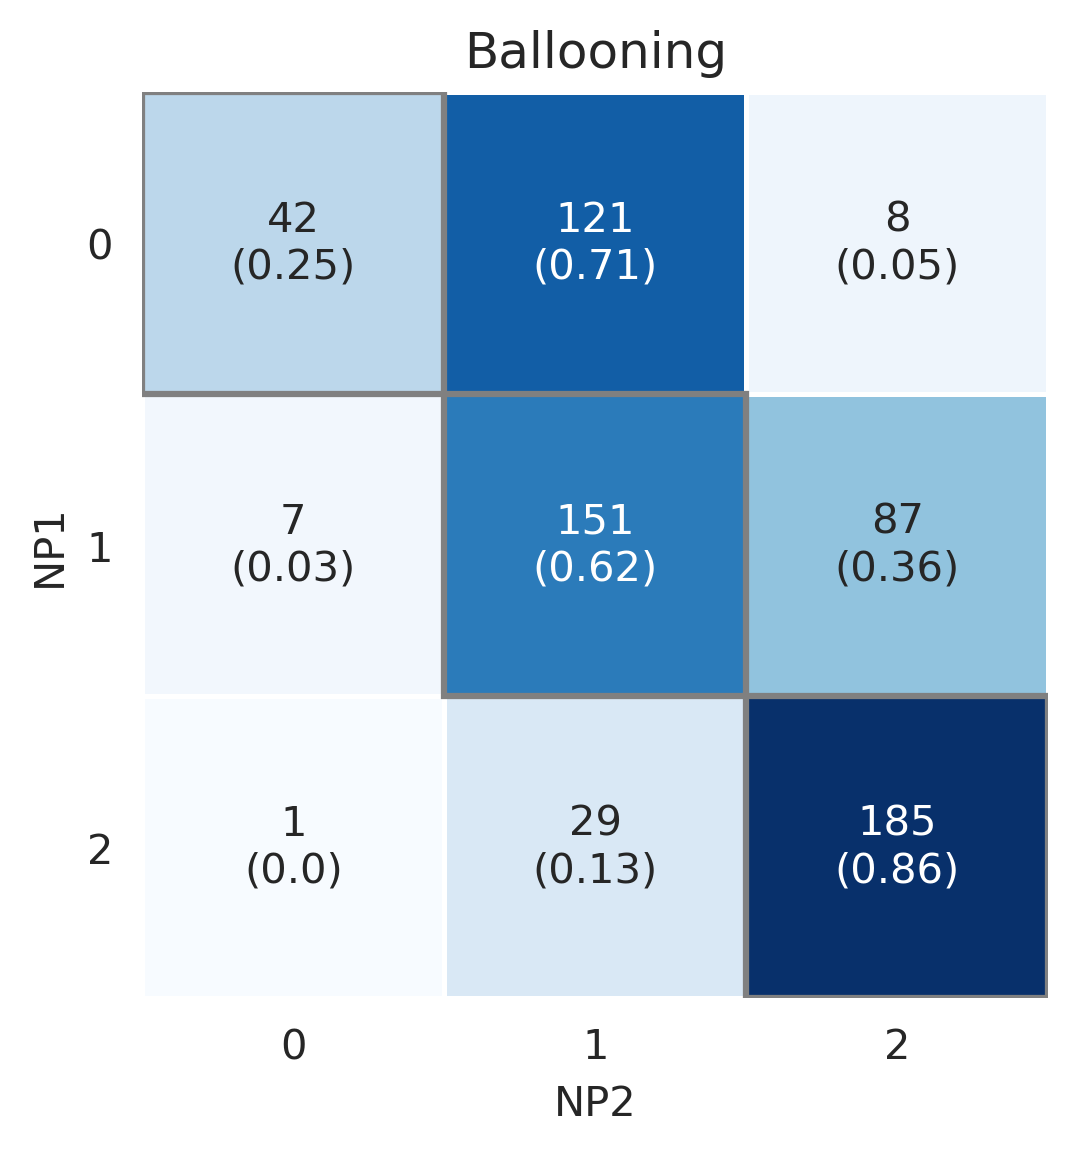

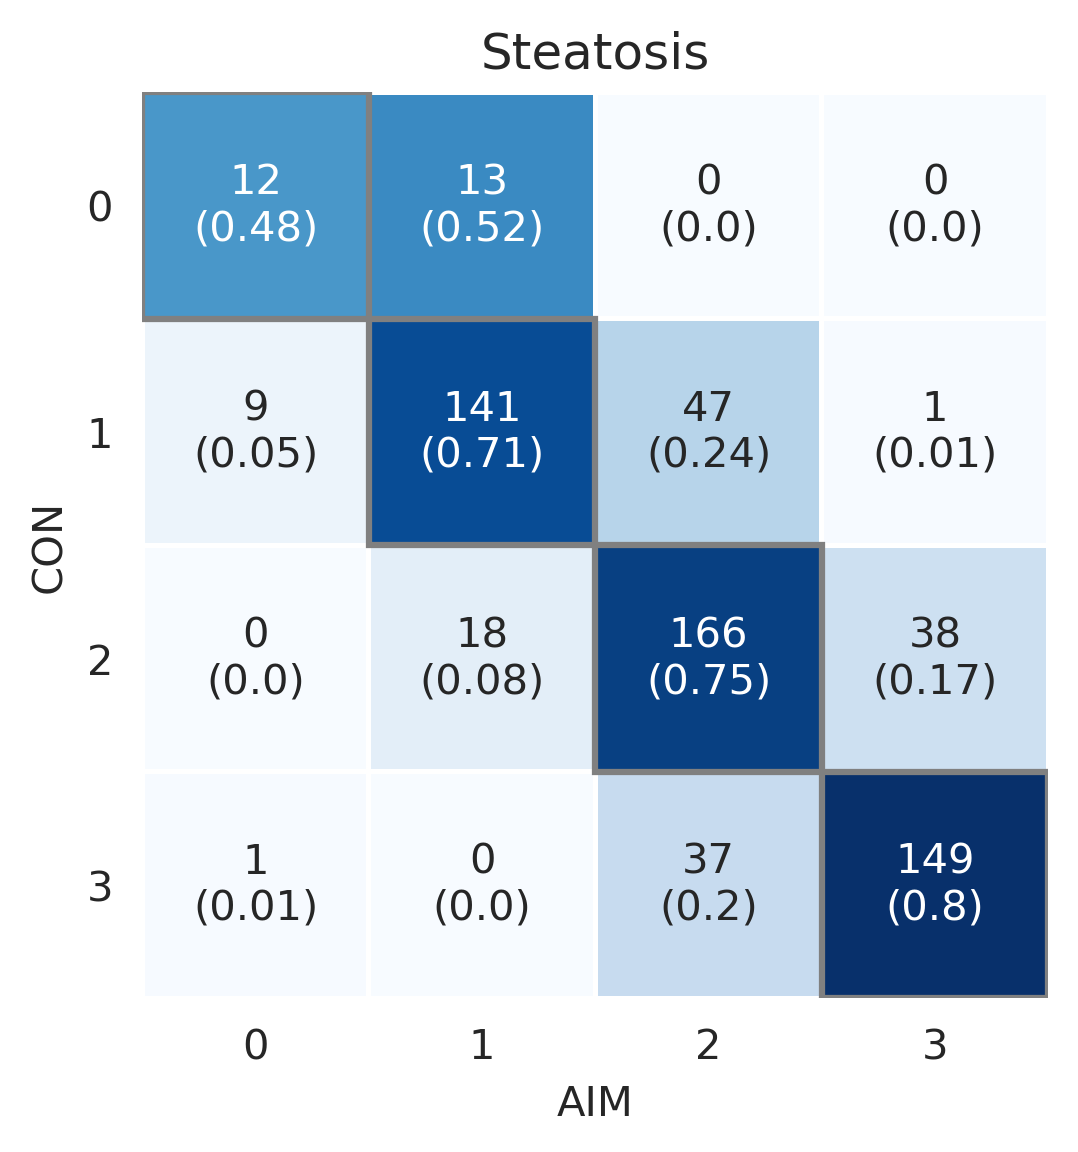

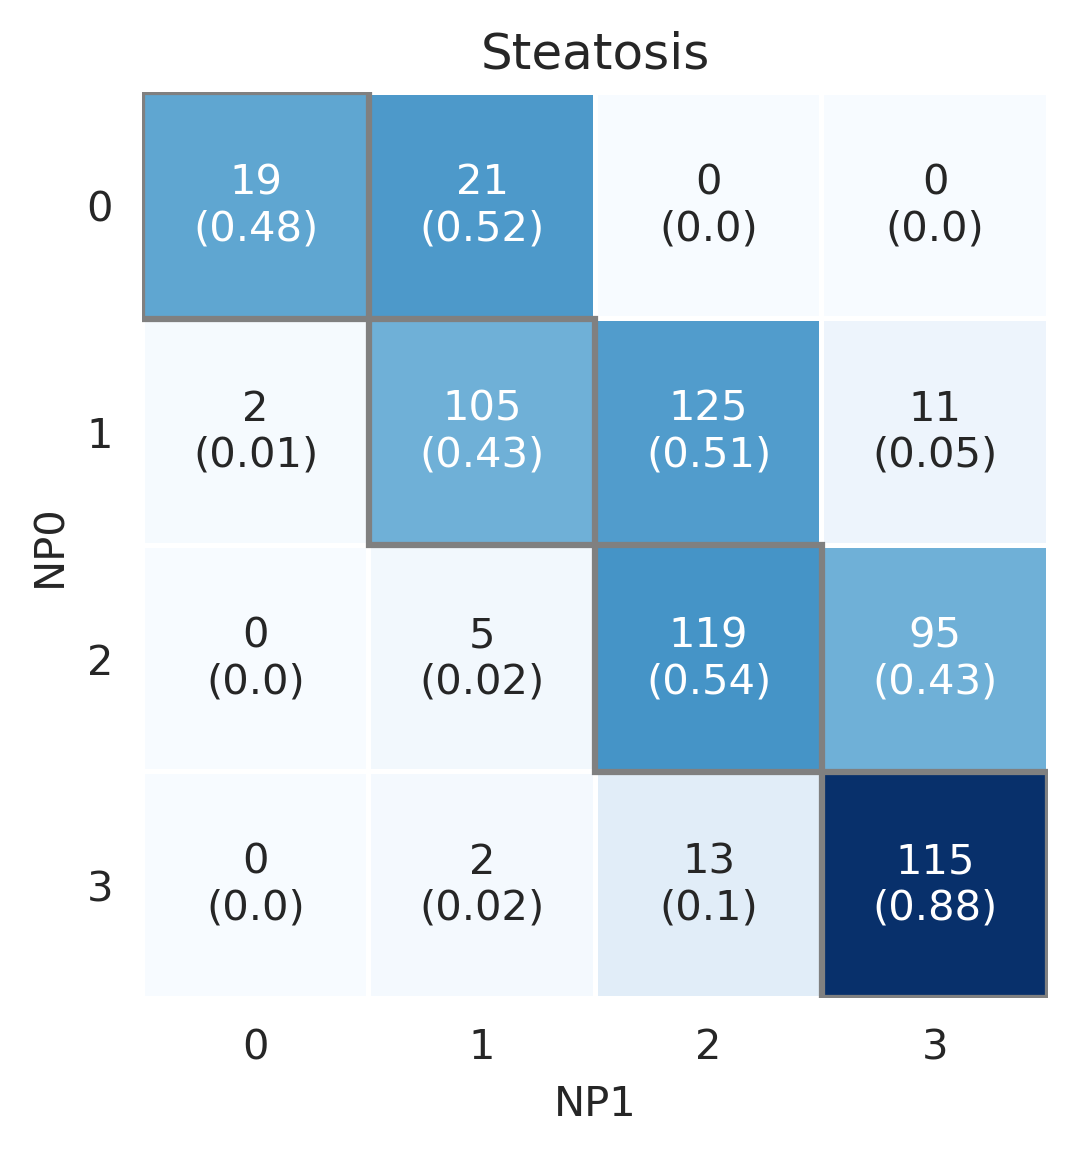

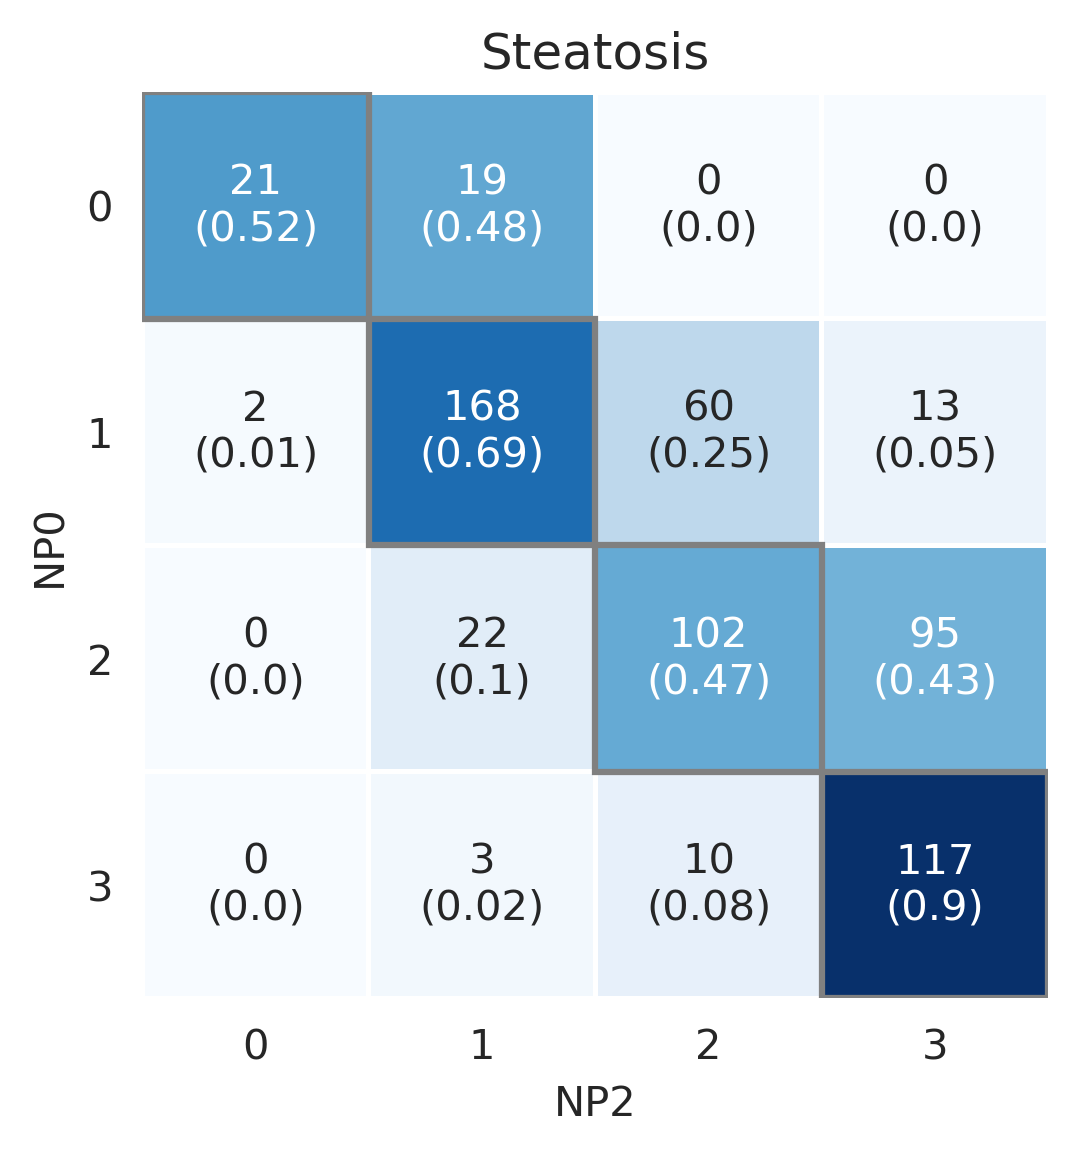

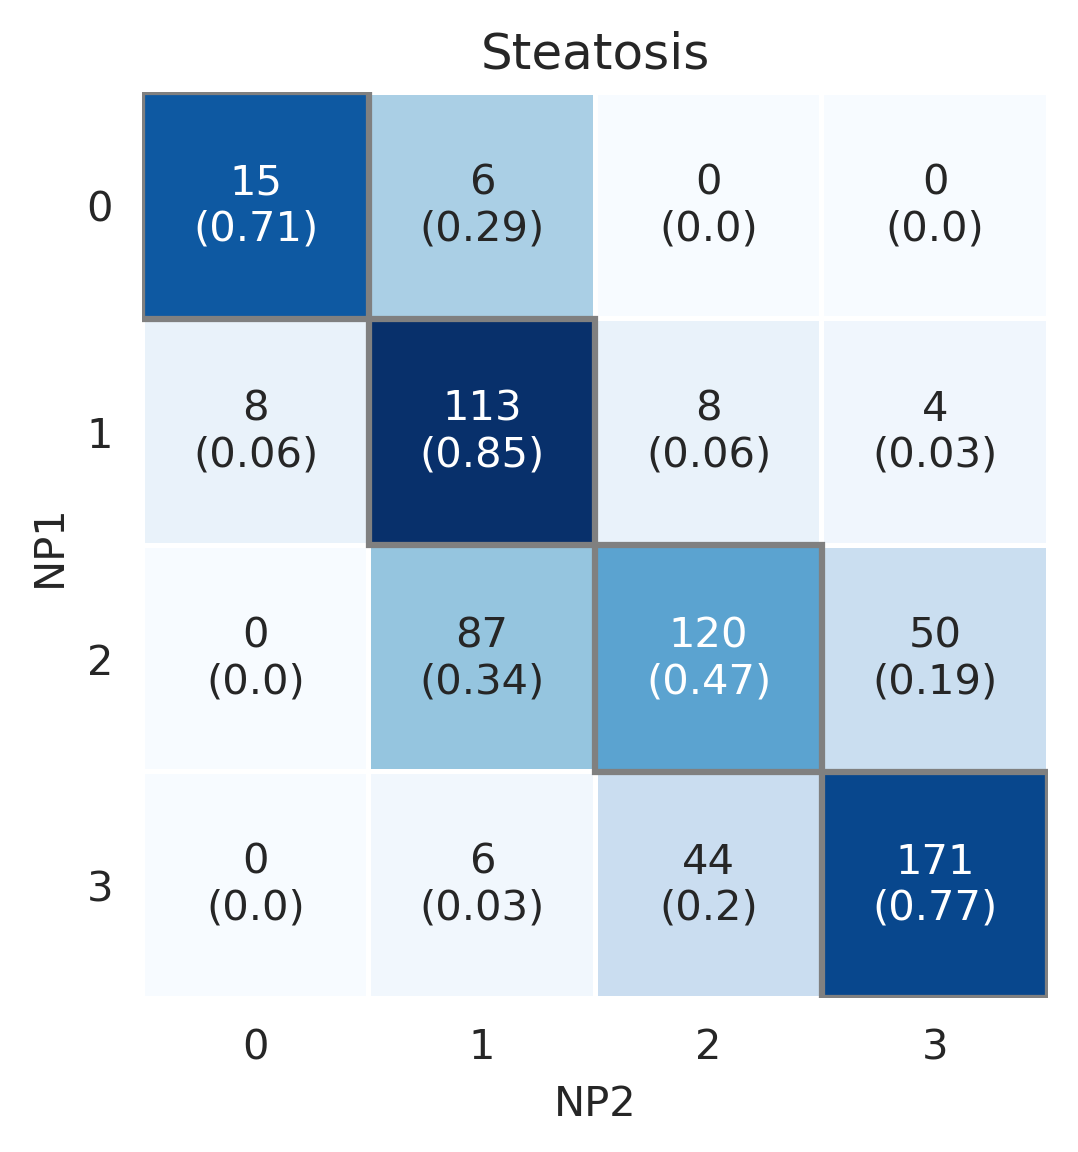

In [170]:
# plots
max_scores = {'Fibrosis':4,'Inflammation':3,'Ballooning':2,'Steatosis':3}
df_list = []

with pd.ExcelWriter('OUTPUTS/CiriusConfusionCounts.xlsx', mode='w') as w:

    for comp, df in c_dfs.items():
        aim = df['AIM']
        np0 = df['NP0']
        np1 = df['NP1']
        np2 = df['NP2']
        aim,np0,np1,np2  = cs.clean_nans([aim,np0,np1,np2])
        con = np.median([np0,np1,np2],axis=0)

        ax, c, r = cs.plot_confusion_table(con,aim,name_a='CON',name_b='AIM',title=comp,max_score=max_scores[comp])
        plt.show()
        c.index.name = c.index.name+ ' v '+c.columns.name
        c.to_excel(w, sheet_name=f'{comp} {c.index.name}')
        
        ax, c, r = cs.plot_confusion_table(np0,np1,name_a='NP0',name_b='NP1',title=comp,max_score=max_scores[comp])
        plt.show()
        c.index.name = c.index.name+ ' v '+c.columns.name
        c.to_excel(w, sheet_name=f'{comp} {c.index.name}')
        ax, c, r = cs.plot_confusion_table(np0,np2,name_a='NP0',name_b='NP2',title=comp,max_score=max_scores[comp])
        plt.show()
        c.index.name = c.index.name+ ' v '+c.columns.name
        c.to_excel(w, sheet_name=f'{comp} {c.index.name}')
        ax, c, r = cs.plot_confusion_table(np1,np2,name_a='NP1',name_b='NP2',title=comp,max_score=max_scores[comp])
        plt.show()
        c.index.name = c.index.name+ ' v '+c.columns.name
        c.to_excel(w, sheet_name=f'{comp} {c.index.name}')

In [ ]:
## enrolement agreement rates
# - [ ] make aim data frame with component column names
# - [ ] make consensus data with component column names

# - [ ] generate enrolement measures

In [36]:
# load Cougar network path data
file = 'REFDATA/COUGAR_NP_V03.xlsx'
c_dfs = {}

c_dfs['Fibrosis'] = pd.read_excel(file, sheet_name='Fibrosis')
c_dfs['Inflammation'] = pd.read_excel(file, sheet_name='Inflammation')
c_dfs['Ballooning'] = pd.read_excel(file, sheet_name='Ballooning')
c_dfs['Steatosis'] = pd.read_excel(file, sheet_name='Steatosis')

In [37]:
c_dfs['Steatosis']

,PATHAI_ID,CASE_NAME,SUBJID,TRT01P,Visit,AIM,NP0,NP1,NP2
0,199158,105-0993,105-0993,MSDC-0602K 250 mg,Month-12,0,1,0.0,1.0
1,199141,182-0933,182-0933,Placebo,Month-12,3,3,3.0,3.0
2,198951,102-0862,102-0862,MSDC-0602K 125 mg,Month-12,2,1,2.0,2.0
3,198950,167-0651,167-0651,Placebo,Month-12,3,2,3.0,2.0
4,198948,167-0840,167-0840,Placebo,Month-12,0,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
634,198962,161-0868,161-0868,Placebo,Month-12,1,1,2.0,1.0
635,198957,181-0816,181-0816,MSDC-0602K 125 mg,Month-12,2,1,2.0,2.0
636,198956,181-0828,181-0828,MSDC-0602K 250 mg,Month-12,2,1,2.0,2.0
637,198955,115-0946,115-0946,Placebo,Month-12,0,0,1.0,0.0


In [ ]:
def pick_col_level(df):
    col_levels = [i[1] if i[1] else i[0] for i in df.columns.to_flat_index()]
    df.columns = col_levels

In [156]:
df_list = []
for comp, df in c_dfs.items():
    df_temp = df.dropna(axis=0).copy()
    df_temp['CON'] = df_temp[['NP0','NP1','NP2']].apply(np.median,axis=1)
    df_temp.drop(columns='PATHAI_ID',inplace=True)
    df_out = pd.melt(df_temp,
                     id_vars=['CASE_NAME','Visit'], 
                     value_vars=['AIM','CON','NP0','NP1','NP2'],
                     var_name='SOURCE', 
                     value_name=comp, 
                     ignore_index=True).reset_index(drop=True)
    df_list.append(df_out)
c_df_tall = reduce(lambda x, y: pd.merge(x, y,how='inner',on=['CASE_NAME','Visit','SOURCE']).drop_duplicates(), df_list).reset_index(drop=True)


In [159]:
enroll_df = c_df_tall.copy()
enroll_df['Enroll FIB >= 4'] = enroll_df.apply(nd.A_F4_enroll,axis=1)
enroll_df['Enroll NAS'] = enroll_df.apply(nd.B_NAS_enroll,axis=1)
enroll_df['Enroll NAS & FIB'] = enroll_df.apply(nd.C_F4_NAS_enroll,axis=1)


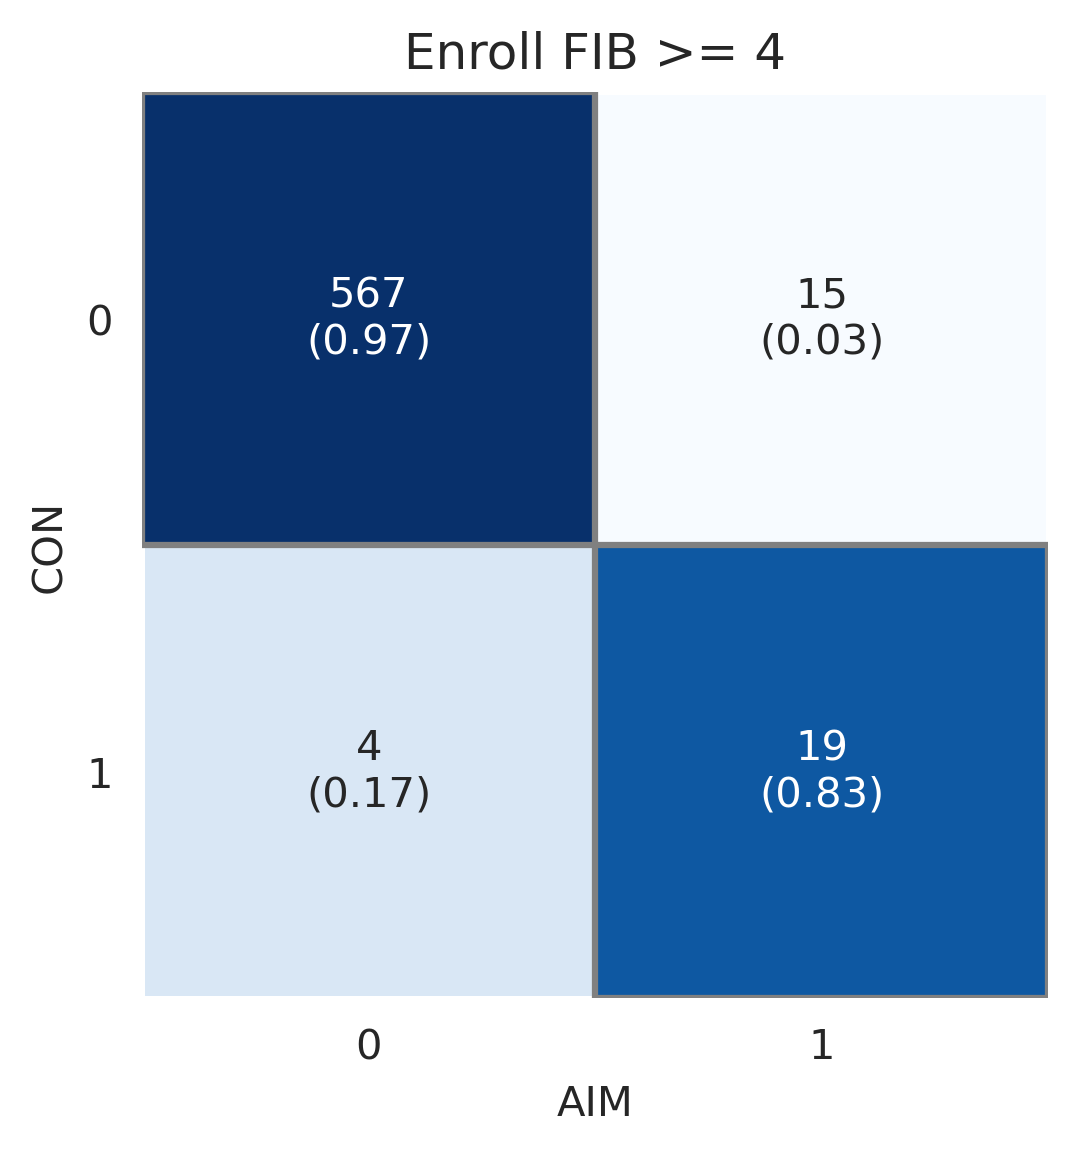

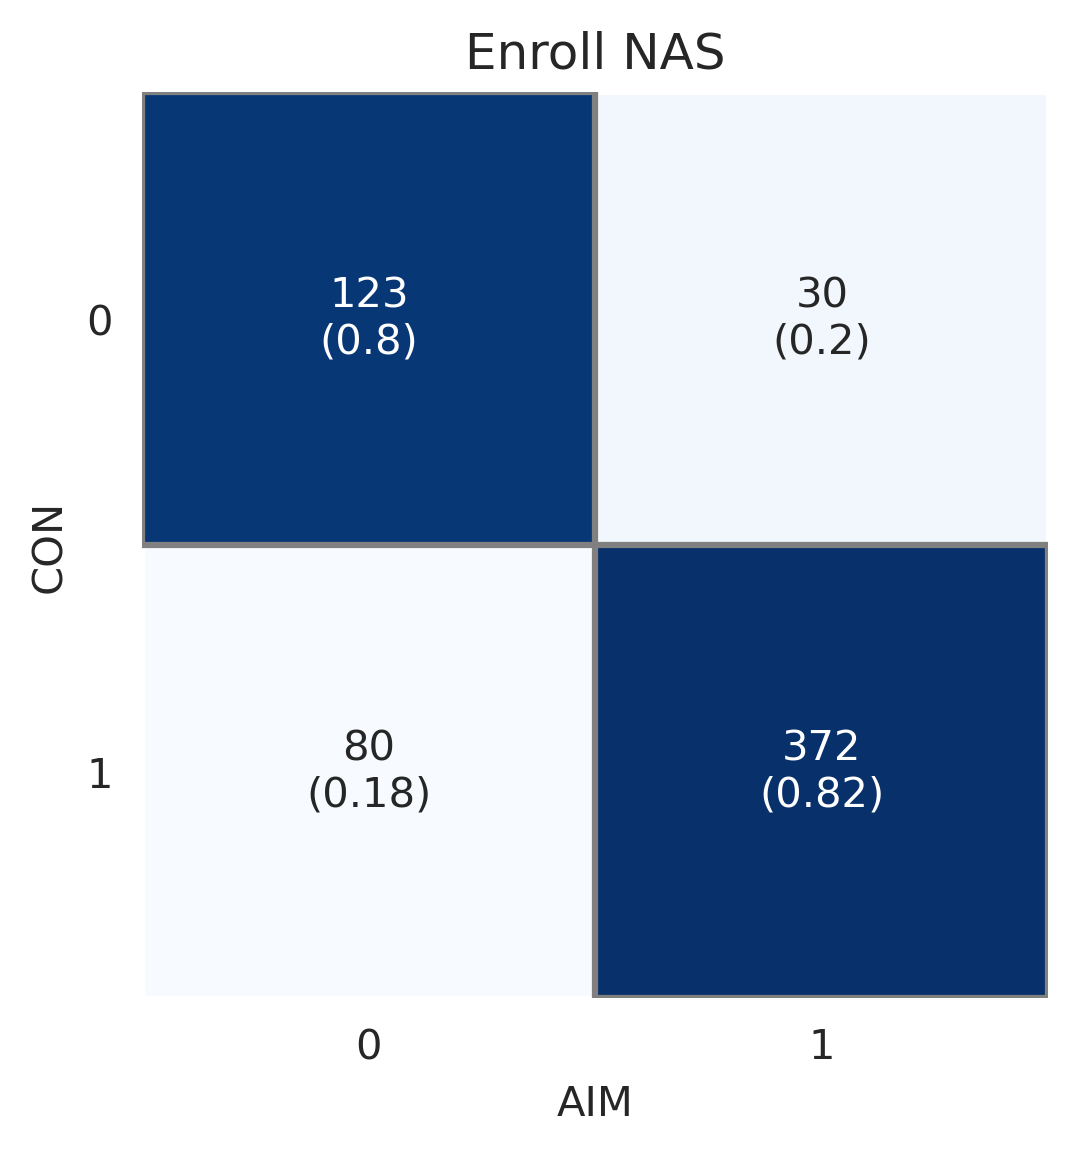

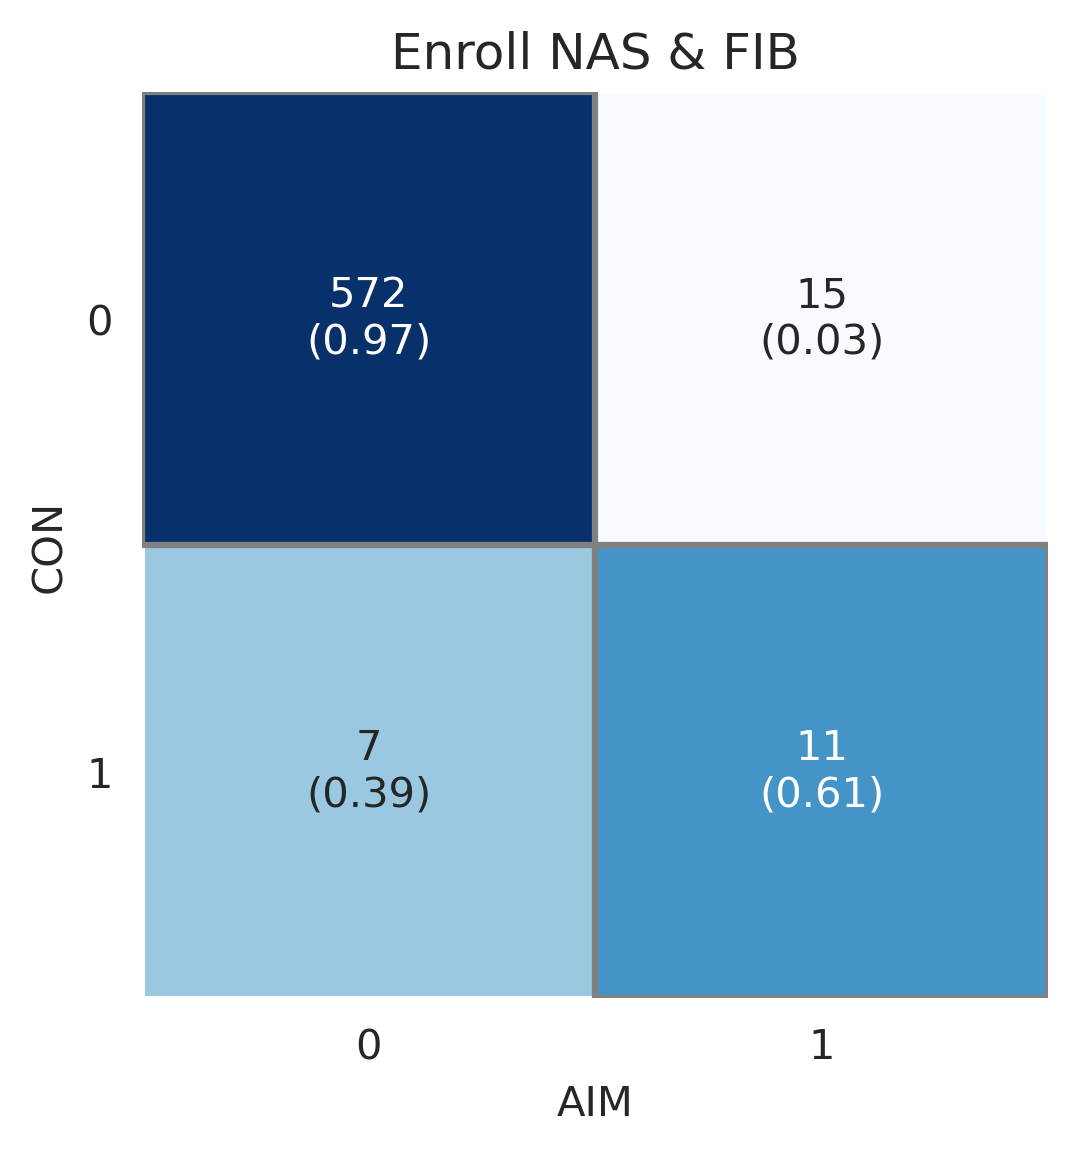

In [196]:
es_list = []
es_pw_list = []
for ep in ['Enroll FIB >= 4','Enroll NAS','Enroll NAS & FIB']:
    a = enroll_df.pivot(
        index=['CASE_NAME','Visit'],
        columns=['SOURCE'],
        values=[ep]
    )
    a = a.reset_index()
    pick_col_level(a)
    
    stats_str, _ = cs.legacy_stats(cs.agg_rate,a['AIM'],a['NP0'],a['NP1'],a['NP2'])
    stats_str['Enrollment Measure']=ep
    stats_str['Metric'] = 'Agreement Rate'
    es_list.append(stats_str)
    
    
    stats_str, _ = cs.pairwise_stats(cs.agg_rate,a['AIM'],a['NP0'],a['NP1'],a['NP2'])
    stats_str['Enrollment Measure']=ep
    stats_str['Metric'] = 'Agreement Rate'
    es_pw_list.append(stats_str)
    
    _ = cs.plot_confusion_table(a['CON'],a['AIM'],name_a='CON',name_b='AIM',title=ep)
    plt.show()
es_leg_stats = pd.concat(es_list)
es_pw_stats = pd.concat(es_pw_list)

In [197]:
es_pw_stats

,AIM PW AVG,NP PW AVG,NP0-NP1,NP0-NP2,NP1-NP2,N,Enrollment Measure,Metric
0,"0.95 (0.93, 0.96)","0.94 (0.92, 0.95)","0.97 (0.95, 0.98)","0.92 (0.9, 0.94)","0.93 (0.91, 0.95)",605,Enroll FIB >= 4,Agreement Rate
0,"0.79 (0.77, 0.82)","0.78 (0.75, 0.8)","0.76 (0.73, 0.8)","0.81 (0.78, 0.84)","0.77 (0.73, 0.8)",605,Enroll NAS,Agreement Rate
0,"0.95 (0.94, 0.97)","0.95 (0.93, 0.96)","0.97 (0.95, 0.98)","0.94 (0.92, 0.95)","0.93 (0.91, 0.95)",605,Enroll NAS & FIB,Agreement Rate


In [199]:
es_leg_stats

,AIM v CON,NP PW AVG,NP0-NP1,NP0-NP2,NP1-NP2,N,Enrollment Measure,Metric
0,"0.97 (0.95, 0.98)","0.94 (0.92, 0.95)","0.97 (0.95, 0.98)","0.92 (0.9, 0.94)","0.93 (0.91, 0.95)",605,Enroll FIB >= 4,Agreement Rate
0,"0.83 (0.8, 0.86)","0.78 (0.76, 0.8)","0.76 (0.73, 0.8)","0.81 (0.78, 0.84)","0.77 (0.73, 0.8)",605,Enroll NAS,Agreement Rate
0,"0.97 (0.95, 0.98)","0.95 (0.93, 0.96)","0.97 (0.95, 0.98)","0.94 (0.92, 0.96)","0.93 (0.91, 0.95)",605,Enroll NAS & FIB,Agreement Rate


In [179]:
a

,level_0,index,CASE_NAME,Visit,AIM,CON,NP0,NP1,NP2
0,0,0,101-0380,Baseline,False,False,False,False,False
1,1,1,101-0380,Month-12,False,False,False,False,False
2,2,2,101-0540,Baseline,False,False,False,False,False
3,3,3,101-0540,Month-12,False,False,False,False,False
4,4,4,101-0600,Baseline,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
600,600,600,183-1048,Baseline,False,False,False,False,False
601,601,601,183-1048,Month-12,False,False,False,False,False
602,602,602,183-1078,Month-12,False,False,False,False,False
603,603,603,184-0865,Baseline,False,False,False,False,False


In [91]:
a = c_df_tall.pivot(
    index=['CASE_NAME','SOURCE'],
    columns=['Visit'],
    values=['Fibrosis','Inflammation','Ballooning','Steatosis']
)

In [149]:
a.loc[(slice(None),'AIM'),(slice(None),'Month-12')].apply(nd.B_NAS_enroll,axis=1).value_counts()

Month-12
True        181
False       128
dtype: int64

In [139]:
b.value_counts()

Baseline  Month-12
False     False       256
True      False        12
False     True         10
True      True          1
dtype: int64

In [154]:
a.loc[(slice(None),'NP2'),(slice(None),'Month-12')].apply(nd.nash_resolution,axis=1).value_counts()

Month-12
False       275
True         34
dtype: int64

In [133]:
a.loc[(slice(None),['NP0','NP1','NP2']),(slice(None),'Baseline')].apply(nd.C_F4_NAS_enroll,axis=1).reset_index(level=[1]).value_counts()

SOURCE  Baseline
NP0     False       296
NP1     False       287
NP2     False       279
        True         17
NP1     True          9
dtype: int64